<a href="https://colab.research.google.com/github/elnazabbasifar/CtCI-6th-Edition-Python/blob/master/RNA_GNN_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GNN Model Comparison on RNA Secondary Structure Data
**Author**: Elnaz Abbasifar  
**Supervisor**: Dr. Gajamannage  
**Date**: Nov 14, 2025

**Objective:** This notebook explores and compares the performance of different Graph Neural Network (GNN) models for the classifying RNA secondary structure graphs.

**Dataset:** RNA secondary structure graphs (13 classes).

**Models Explored:**
*   Graph Isomorphism Network (GIN)
*   Graph Attention Network (GAT)
*   DiffPool (Hierarchical Pooling with GCN-based layers)

**Implementation Details:**
*   Utilizes the DGL library for graph handling and PyTorch for model implementation.
*   Node features are derived from graph structure (degree, depth, subtree size, leaf status, number of children).
*   A custom **BANANAS Architecture Optimization** approach is implemented for architecture.
*   A **MANGO Hyperparameter Tuning library** is used.

**Results:** Achieved an average test accuracy of approximately 0.3985, 0.3965, 0.3954 for GIN, GAT, and DiffPool models, respectively.
*   Detailed metrics and comparison tables are provided later in the notebook.

**Setup: install and import libraries**  

In [1]:
!pip uninstall -y dgl torch torchdata torchaudio torchvision

Found existing installation: torch 2.8.0+cu126
Uninstalling torch-2.8.0+cu126:
  Successfully uninstalled torch-2.8.0+cu126
Found existing installation: torchdata 0.11.0
Uninstalling torchdata-0.11.0:
  Successfully uninstalled torchdata-0.11.0
Found existing installation: torchaudio 2.8.0+cu126
Uninstalling torchaudio-2.8.0+cu126:
  Successfully uninstalled torchaudio-2.8.0+cu126
Found existing installation: torchvision 0.23.0+cu126
Uninstalling torchvision-0.23.0+cu126:
  Successfully uninstalled torchvision-0.23.0+cu126


**Objective:** This notebook explores and compares the performance of different Graph Neural Network (GNN) models for classifying RNA secondary structure graphs.

**Dataset:** RNA secondary structure graphs (13 classes).

**Models Explored:**
*   Graph Isomorphism Network (GIN)
*   Graph Attention Network (GAT)
*   DiffPool (Hierarchical Pooling with GCN-based layers)

**Implementation Details:**
*   Utilizes the DGL library for graph handling and PyTorch for model implementation.
*   Node features are derived from graph structure (degree, depth, subtree size, leaf status, number of children).
*   A custom **BANANAS-inspired Bayesian Optimization** approach is implemented for hyperparameter tuning.
*   Training includes techniques like **Learning Rate Scheduling** and **Gradient Clipping**.

**Results:** Achieved average test accuracies of approximately 0.3985 for GIN, 39.65% for GAT, and 39.54% for DiffPool models.
*   Detailed metrics and comparison tables are provided later in the notebook.

In [ ]:
# Install PyTorch Geometric
!pip install --quiet torch-geometric
!pip install --quiet torch torchvision torchaudio scikit-learn matplotlib optuna
!pip install  dgl -f https://data.dgl.ai/wheels/torch-2.1/repo.html

In [ ]:
# Clone the MANGO repository
!pip install git+https://github.com/ARM-software/mango.git

In [ ]:
# Clone the BANANAS repository
# !git clone https://github.com/naszilla/naszilla.git


In [ ]:
# # Return to the main naszilla directory
# %cd /content/naszilla

# # Check if setup.py is really here
# !ls

# # Now remove lines related to tensorflow, torch, and ConfigSpace
# !sed -i "/'tensorflow-gpu==1.14.0',/d" setup.py
# !sed -i "/'tensorflow==1.14.0',/d" setup.py
# !sed -i "/'torch==1.5.0',/d" setup.py
# !sed -i "/'torchvision==0.6.0',/d" setup.py
# !sed -i "/'ConfigSpace==0.4.12',/d" setup.py
# !sed -i "/'ConfigSpace==0.4.12',/d" setup.py

# # Explicitly install a compatible ConfigSpace dependency
# !pip install ConfigSpace

# # Install naszilla without TensorFlow, old Torch, and ConfigSpace (after removing dependencies)
# !pip install -e .

In [58]:
# General imports
import os, pickle

# Data science imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix

# Graph imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch_geometric.nn import DenseGCNConv, dense_diff_pool

import dgl
from dgl.dataloading import GraphDataLoader
from dgl.nn.pytorch import GINConv, GATConv, GraphConv #, DenseGraphConv

import random
import copy
from collections import deque, Counter

# Optimization imports
#from naszilla.nas_algorithms import bananas
from mango import scheduler, Tuner
from functools import partial
import itertools
from sklearn.neural_network import MLPRegressor

# reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cpu


In [6]:
print("PyTorch version:", torch.__version__)
print("DGL version:", dgl.__version__)
print("CUDA available:", torch.cuda.is_available())

PyTorch version: 2.4.0+cu121
DGL version: 2.4.0
CUDA available: False


In [7]:
# current directory
!pwd

/content


In [8]:
# link to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This notebook implements three GNN variants (GIN, GAT, DiffPool) for graph-level multi-class classification.  
Structure:
1. Data loading & preprocessing
2. DataLoaders
3. Model definitions (GIN, GAT, DiffPool)
4. Training loop and evaluation functions (AUC-ROC, AUC-PR, misclassification ratio)
5. Hyperparameter tuning
6. Run experiments (using best hyperparameters ) and compare results

### 1. Dataset preparation

**Load ncRNA Dataset**

In [33]:
# Load provided pickle files and inspect a sample entry
data_dir = "/content/drive/MyDrive/Projects/RNA/data"
train_pkl = os.path.join(data_dir, "training6320_parent_list_type1.pkl")
test_pkl  = os.path.join(data_dir, "testing2600_parent_list_type1.pkl")

# Load files
with open(train_pkl, 'rb') as f:
    train_data = pickle.load(f)   # expected: list/array of dicts, each dict has keys 'parent_list' and 'label'

with open(test_pkl, 'rb') as f:
    test_data = pickle.load(f)

print("Train samples:", len(train_data))
print("Test samples :", len(test_data))

# Inspect a single entry
print("Example entry keys:", train_data[0].keys())
print("Example parent_list shape:", np.array(train_data[0]['parent_list']).shape)
print("Example label:", train_data[0]['label'])

Train samples: 6320
Test samples : 2600
Example entry keys: dict_keys(['parent_list', 'label'])
Example parent_list shape: (10, 2)
Example label: 5S_rRNA


**Preprocess data**

In [34]:
# Combine labels from train and test data
all_labels = [d['label'] for d in train_data] + [d['label'] for d in test_data]
le = LabelEncoder()
le.fit(all_labels)

# Create a consistent label-to-index mapping (sorted alphabetically for reproducibility)
#label_encoder = {lbl: idx for idx, lbl in enumerate(sorted(set(all_labels)))}
#label_decoder = {v: k for k, v in label_encoder.items()}

# Number of classes
num_classes = len(le.classes_)
# List of class names
class_names = list(le.classes_)
print("Number of classes:", num_classes)
print("Class names:", class_names)

Number of classes: 13
Class names: [np.str_('5S_rRNA'), np.str_('5_8S_rRNA'), np.str_('CD-box'), np.str_('HACA-box'), np.str_('IRES'), np.str_('Intron_gpI'), np.str_('Intron_gpII'), np.str_('leader'), np.str_('miRNA'), np.str_('riboswitch'), np.str_('ribozyme'), np.str_('scaRNA'), np.str_('tRNA')]


**Convert raw `parent_list` dictionaries to DGL graphs**  
- `dict_entry_to_dglgraph` function builds an undirected DGL graph from the parent_list. node features store in `g.ndata['feat']` (repeated per node for convenience).

- `compute_tree_node_features` function computes structural node features (degree, normalized depth, subtree size, is_leaf, num_children).

In [35]:
# Helper functions to convert parent_list -> DGLGraph
def parent_list_to_edges(parent_list):
    """
    parent_list: numpy array of shape (N,2) with rows [node_idx, parent_idx]
    where col0=node_idx, col1=parent_idx (-1 for root)
    Returns src_list, dst_list for undirected edges (we add both directions). We'll use undirected edges for GNN.
    """
    edges_src = [] # a list of source of an edge
    edges_dst = [] # a list of destination of an edge
    for row in parent_list:
        u = int(row[0]) # node
        p = int(row[1]) # parent
        if p == -1:
            continue
        # add bidirectional edges (undirected)
        edges_src.extend([u, p])
        edges_dst.extend([p, u])
    return edges_src, edges_dst

# We create structural features because the provided entries contain topology only.
def compute_tree_node_features(parent_list):
    """
    Compute simple node-level features for each node in the tree:
    - degree (undirected)
    - depth from root (root depth=0)
    - subtree size (number of descendants)
    Returns: numpy array shape (N, 3), dtype float32
    """
    parent_list = np.array(parent_list, dtype=int)
    n_nodes = int(parent_list[:,0].max()) + 1 if parent_list.size > 0 else 0

    N = parent_list.shape[0]
    parent = {int(r[0]): int(r[1]) for r in parent_list}
    children = {i: [] for i in range(N)}
    children_count = np.zeros(n_nodes, dtype=int)
    roots = []
    for node, p in parent.items():
        if p == -1:
            roots.append(node)
        else:
            children[p].append(node)
            children_count[p] += 1

    # Structural features
    # degree (undirected)
    deg = np.zeros(N, dtype=np.float32)
    for u in range(N):
        d = len(children[u])
        if parent[u] != -1:
            d += 1
        deg[u] = d
    is_leaf = (children_count == 0).astype(float)
    num_children = children_count.astype(float)

    # depth(s): BFS from each root (handle forest)
    depth = np.zeros(N, dtype=np.float32)
    if len(roots) == 0:
        roots = [0]  # fallback
    visited = set()
    q = deque()
    for r in roots:
        q.append((r, 0))
        visited.add(r)
    while q:
        u, d = q.popleft()
        depth[u] = d
        for v in children[u]:
            if v not in visited:
                visited.add(v)
                q.append((v, d+1))

    # subtree sizes using post-order DFS (handle forest)
    subtree = np.zeros(N, dtype=np.float32)
    def compute_subtree(u):
        s = 1
        for v in children[u]:
            s += compute_subtree(v)
        subtree[u] = s
        return s
    for r in roots:
        compute_subtree(r)

    # normalize depth and subtree to [0,1]
    if depth.max() > 0:
        depth_norm = depth / (depth.max() + 1e-12)
    else:
        depth_norm = depth
    if subtree.max() > 0:
        subtree_norm = subtree / (subtree.max() + 1e-12)
    else:
        subtree_norm = subtree

    feats = np.stack([deg, depth_norm, subtree_norm, is_leaf, num_children], axis=1).astype(np.float32)
    return feats

def dict_entry_to_dglgraph(entry):
    """
    Convert a dictionary entry {'parent_list':..., 'label':...} to (dgl_graph, label).
    Node features are structural features computed above and stored as 'feat'.
    entry: dict with keys 'parent_list' (np.array Nx2) and 'label'
    returns: DGLGraph with g.ndata['feat'] (torch.float32) and g.ndata['label']
    """
    parent_list = np.array(entry['parent_list'], dtype=int)

    # assume parent_list rows are [node_idx, parent_idx]
    src, dst = parent_list_to_edges(parent_list)

    # create graph with N nodes
    n_nodes = parent_list.shape[0]
    if len(src) == 0:
        # isolated single-node tree
        g = dgl.graph(([], []), num_nodes=n_nodes)
    else:
        g = dgl.graph((src, dst), num_nodes=n_nodes)

    #g = dgl.reorder_graph(g) if g.num_nodes()!=n_nodes else g
    # create node features
    feats = compute_tree_node_features(parent_list)
    g.ndata['feat'] = torch.tensor(feats)

    # Use global LabelEncoder 'le'
    label_idx = le.transform([entry['label']])[0]
    g.graph_label = torch.tensor([label_idx], dtype=torch.long)

    return g


**Convert data to graphs**

In [36]:
# Convert entries -> graphs and labels lists
train_graphs = [dict_entry_to_dglgraph(e) for e in train_data]
train_labels_int = le.transform([e['label'] for e in train_data])   # shape (N,)
test_graphs  = [dict_entry_to_dglgraph(e) for e in test_data]
test_labels_int  = le.transform([e['label'] for e in test_data])

print('Train graphs:', len(train_graphs), 'Test graphs:', len(test_graphs))
print("Example nodes in graph 0", train_graphs[0].num_nodes(), "feat shape", train_graphs[0].ndata['feat'].shape)

Train graphs: 6320 Test graphs: 2600
Example nodes in graph 0 10 feat shape torch.Size([10, 5])


**Normalize node features**

In [37]:
# 1) Compute mean/std from TRAIN graphs ONLY
all_feats = torch.cat([g.ndata['feat'] for g in train_graphs], dim=0)
mean = all_feats.mean(0)
std  = all_feats.std(0) + 1e-6

# 2) Apply on TRAIN
for g in train_graphs:
    g.ndata['feat'] = (g.ndata['feat'] - mean) / std

# 3) Apply SAME normalization on TEST
for g in test_graphs:
    g.ndata['feat'] = (g.ndata['feat'] - mean) / std

**Class distribution**

Train class counts:
  class 0: 500
  class 1: 500
  class 2: 500
  class 3: 500
  class 4: 320
  class 5: 500
  class 6: 500
  class 7: 500
  class 8: 500
  class 9: 500
  class 10: 500
  class 11: 500
  class 12: 500
Test class counts:
  class 0: 200
  class 1: 200
  class 2: 200
  class 3: 200
  class 4: 200
  class 5: 200
  class 6: 200
  class 7: 200
  class 8: 200
  class 9: 200
  class 10: 200
  class 11: 200
  class 12: 200


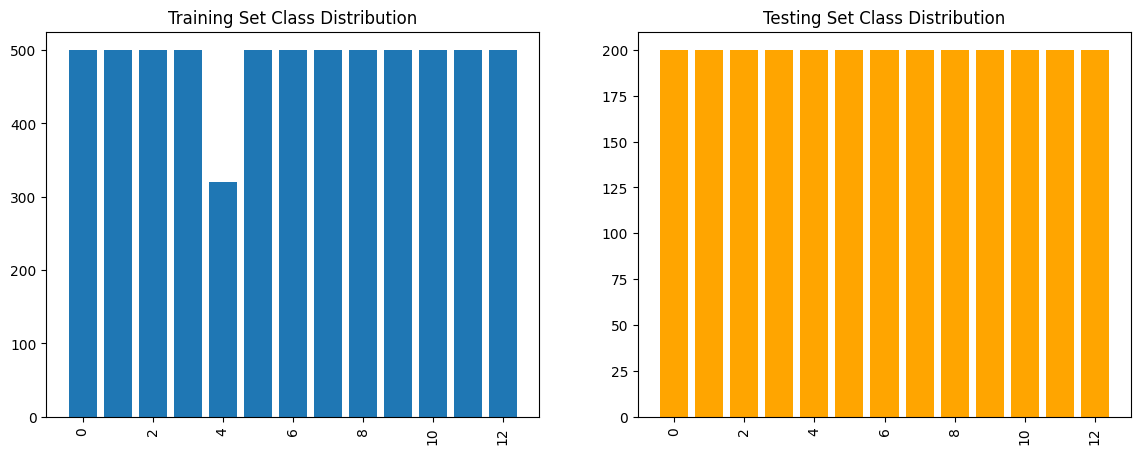

In [38]:
# Check class distribution
def extract_graph_label(g):
    # The graph label is stored in g.graph_label
    if hasattr(g, 'graph_label') and g.graph_label is not None and len(g.graph_label) > 0:
        return int(g.graph_label.item())
    else:
        # If no graph label is found (e.g., for a graph with no nodes), handle appropriately
        # For this dataset, all graphs should have a label, but we add a check.
        # Returning -1 or raising an error depends on how you want to handle such cases.
        # Since all graphs in this dataset should have labels, raising an error is reasonable.
        raise RuntimeError('Graph label not found in g.graph_label.')

train_labels = [extract_graph_label(g) for g in train_graphs]
test_labels  = [extract_graph_label(g) for g in test_graphs]
unique, counts = np.unique(train_labels, return_counts=True)
print('Train class counts:')
for u,c in zip(unique, counts):
    print(f'  class {u}: {c}')
unique_t, counts_t = np.unique(test_labels, return_counts=True)
print('Test class counts:')
for u,c in zip(unique_t, counts_t):
    print(f'  class {u}: {c}')

# --- Visualization ---
train_counts = Counter(train_labels)
test_counts = Counter(test_labels)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(train_counts.keys(), train_counts.values())
axes[0].set_title("Training Set Class Distribution")
axes[0].tick_params(axis='x', rotation=90)

axes[1].bar(test_counts.keys(), test_counts.values(), color='orange')
axes[1].set_title("Testing Set Class Distribution")
axes[1].tick_params(axis='x', rotation=90)

plt.show()

The dataset is generally well-balanced across classes. Most classes in the training set have 500 samples, while class 4 has slightly fewer (320 samples), indicating a minor imbalance.  
The test set is perfectly balanced, with 200 samples for each class.  
Overall, the data distribution is nearly uniform, with only a small deviation for class 4.

### 2. DataLoaders

**Define DataLoaders**

In [56]:
from torch.utils.data import random_split

class ListGraphDataset(Dataset):
    def __init__(self, graphs, labels):
        assert len(graphs) == len(labels)
        self.graphs = graphs
        self.labels = torch.tensor(labels, dtype=torch.long)
    def __len__(self):
        return len(self.graphs)
    def __getitem__(self, idx):
        return self.graphs[idx], self.labels[idx]

# Create dataset objects
train_dataset = ListGraphDataset(train_graphs, train_labels_int)
test_dataset  = ListGraphDataset(test_graphs, test_labels_int)

# create internal split (85/15)
N = len(train_dataset)
n_val = int(0.15 * N)
n_train = N - n_val
gen = torch.Generator().manual_seed(seed)
train_subset, val_subset = random_split(train_dataset, [n_train, n_val], generator=gen)

# Basic dataloaders (batch size to be tuned later)
# DataLoaders: each batch yields (batched_graphs, labels_tensor)
batch_size = 64
train_loader = GraphDataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader   = GraphDataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader  = GraphDataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Train size:", len(train_subset), "Val size:", len(val_subset), "Test size:", len(test_dataset))


Train size: 5372 Val size: 948 Test size: 2600


### 3. Model definitions

**Define models (GIN, GAT, DiffPool)**

Three GNN variants with increasing architectural complexity and representational power are defined:

- **GIN (Graph Isomorphism Network)**  
  A strong baseline with MLP-based aggregation due to its high discriminative capacity for graph structures.  
  GIN captures subtle differences in topology, making it particularly suitable for structured biological data such as RNA secondary trees.

- **GAT (Graph Attention Network)**  
  Extends GIN by introducing attention mechanisms, allowing the model to assign different weights to neighboring nodes to learn which neighboring nodes are more informative.  
  This selective aggregation improves performance in heterogeneous or irregular graph structures.

- **DiffPool (Differentiable Pooling Network)**  
  Adds a hierarchical pooling layer that clusters nodes during learning. This is especially useful for capturing multi-level or modular organization in RNA secondary structures.

This sequence — **GIN → GAT → DiffPool** — provides a logical progression from simple neighborhood aggregation, to adaptive attention mechanisms, and finally to hierarchical graph abstraction.  
It allows for a deeper understanding of how structural modeling complexity impacts ncRNA classification performance.


In [40]:
#Define GIN and GAT models that operate on DGL batched graphs.
class GINNet(nn.Module):
    """
    GIN-based graph-level classifier using sum-aggregation MLP per node,
    followed by graph readout (mean) and classifier.
    """
    def __init__(self, in_feats, hidden_dim, num_classes, n_layers, dropout):
        super().__init__()
        self.layers = nn.ModuleList()
        self.bns = nn.ModuleList()
        for i in range(n_layers):
            mlp = nn.Sequential(
                nn.Linear(in_feats if i==0 else hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim)
            )
            self.layers.append(GINConv(mlp, 'sum'))
            self.bns.append(nn.BatchNorm1d(hidden_dim))
        self.dropout = nn.Dropout(dropout)
        self.readout = nn.Linear(hidden_dim, num_classes)

    def forward(self, g, feats):
        h = feats
        for conv, bn in zip(self.layers, self.bns):
            h = conv(g, h)
            h = bn(h)
            h = F.relu(h)
            h = self.dropout(h)
        # graph-level readout (mean)
        g.ndata['h'] = h
        hg = dgl.mean_nodes(g, 'h')
        return self.readout(hg)

class GATNet(nn.Module):
    """
    Multi-head GAT for node embeddings, then graph-level readout + classifier.
    """
    # Corrected order of parameters
    def __init__(self, in_feats, hidden_dim, num_classes, num_heads=4, n_layers=2, dropout=0.5):
        super().__init__()
        self.layers = nn.ModuleList()
        self.num_heads = num_heads
        # input layer
        self.layers.append(GATConv(in_feats, hidden_dim // num_heads, num_heads,
                                   feat_drop=dropout, attn_drop=dropout, activation=F.elu))
        # hidden layers
        for _ in range(n_layers-1):
            self.layers.append(GATConv(hidden_dim, hidden_dim // num_heads, num_heads,
                                       feat_drop=dropout, attn_drop=dropout, activation=F.elu))
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, g, feats):
        h = feats
        for layer in self.layers:
            h = layer(g, h)
            if isinstance(h, tuple):
                h = h[0]
            if h.dim() == 3:
                # flatten multi-head output (N, heads, out_dim) -> (N, heads*out_dim)
                h = h.view(h.size(0), -1)
            h = self.dropout(h)
        g.ndata['h'] = h
        hg = dgl.mean_nodes(g, 'h')
        return self.fc(hg)

class DiffPoolNet(nn.Module):
    def __init__(self, in_feats, hidden_dim, embed_dim, assign_dim, num_classes, dropout=0.5):
        super().__init__()
        # Minimal two-layer conv + readout
        self.conv1 = GraphConv(in_feats, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)
        self.dropout = nn.Dropout(dropout)
    def forward(self, g, feats):
        h = F.relu(self.conv1(g, feats))
        h = self.dropout(h)
        h = F.relu(self.conv2(g, h))
        g.ndata['h'] = h
        hg = dgl.mean_nodes(g, 'h')
        return self.fc(hg)

### 4. Training and Evaluation Utils

**Evaluate metrics**

Functions to collect logits/labels, compute AUC-ROC (macro), AUC-PR (macro), accuracy and misclassification percentage.


In [68]:
def evaluate_metrics_collect(model, dataloader, device):
    """
    Evaluate model on dataloader, collect logits and labels.
    Args:
      model: GNN model
      dataloader: GraphDataLoader object
    Returns:
      metrics (dict) :
        - Loss (BCEWithLogits)
        - Accuracy (multi-label)
        - AUC-ROC (macro)
        - AUC-PR (macro)
        - Misclassification Percentage,
      logits (Tensor: N x C),
      labels (Tensor: N)
    """
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    all_logits = []
    all_labels = []
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for batched_graphs, labels in dataloader:
            batched_graphs = batched_graphs.to(device)
            feats = batched_graphs.ndata['feat'].float().to(device)
            labels = labels.to(device)

            logits = model(batched_graphs, feats)   # (B, C)
            loss = loss_fn(logits, labels)

            all_logits.append(logits.cpu())
            all_labels.append(labels.cpu())

            total_loss += loss.item() * labels.size(0)
            total_samples += labels.size(0)

    logits_all = torch.cat(all_logits, dim=0)
    labels_all = torch.cat(all_labels, dim=0)
    avg_loss = total_loss / total_samples

    probs = torch.softmax(logits_all, dim=1).numpy()
    labels_np = labels_all.numpy()
    preds = np.argmax(probs, axis=1)

    acc = accuracy_score(labels_np, preds)
    misclass_pct = (1.0 - acc) * 100.0

    # Macro AUC/PR
    try:
        y_true_bin = label_binarize(labels_np, classes=np.arange(probs.shape[1]))
        auc_roc = roc_auc_score(y_true_bin, probs, average='macro')
        auc_pr = average_precision_score(y_true_bin, probs, average='macro')
    except Exception:
        auc_roc, auc_pr = float('nan'), float('nan')

    metrics = {
        'loss': avg_loss,
        'accuracy': float(acc),
        'auc_roc': float(auc_roc),
        'auc_pr': float(auc_pr),
        'misclassification_pct': float(misclass_pct)
    }
    return metrics, logits_all, labels_all

**Train models**

In [42]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=30):
    """
    Train the model and record losses for training and validation sets.
    Returns a history dictionary containing losses and accuracies.
    Args:
        model: DGL GNN model
        train_loader, val_loader: GraphDataLoader objects
        loss_fn: CrossEntropyLoss()
        optimizer: torch optimizer
        device: cuda or cpu
        num_epochs: training epochs
    Returns:
        model: trained model
        history: dict of losses and accuracies
    """

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    model.to(device)

    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for batched_graphs, labels in train_loader:
            batched_graphs = batched_graphs.to(device)
            feats = batched_graphs.ndata['feat'].float().to(device)
            labels = labels.to(device)  # shape: (batch_size,)

            logits = model(batched_graphs, feats)  # expected shape: (B, C)
            loss = loss_fn(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # accumulate
            total_loss += loss.item() * labels.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = total_loss / total
        train_acc = correct / total

        # Evaluate on validation
        val_metrics, _, _ = evaluate_metrics_collect(model, val_loader, device)
        val_loss = val_metrics["loss"]
        val_acc = val_metrics["accuracy"]

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(val_metrics["loss"])
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_metrics["accuracy"])

        print(f"Epoch {epoch:02d}: TrainLoss={avg_train_loss:.4f}, ValLoss={val_metrics['loss']:.4f}, "
              f"TrainAcc={train_acc:.4f}, ValAcc={val_metrics['accuracy']:.4f}")

    return model, history

def evaluate_model(model, test_loader, device):
    """
    Evaluate the model on test data and compute metrics.
    """
    metrics, logits, labels = evaluate_metrics_collect(model, test_loader, device)
    print(f"Test Accuracy={metrics['accuracy']:.4f}, "
          f"AUC-ROC={metrics['auc_roc']:.4f}, AUC-PR={metrics['auc_pr']:.4f}, "
          f"Misclass%={metrics['misclassification_pct']:.2f}")
    return metrics

In [43]:
def plot_loss_curves(history, model_name="Model"):
    """
    Plot training and validation loss/accuracy curves.
    Helps visualize possible overfitting.
    """
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    epochs = range(1, len(history["train_loss"]) + 1)

    # Plot Loss
    ax[0].plot(epochs, history["train_loss"], label="Train Loss")
    ax[0].plot(epochs, history["val_loss"], label="Val Loss", linestyle="--")
    ax[0].set_title(f"{model_name} - Loss Curves")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].legend()

    # Plot Accuracy
    ax[1].plot(epochs, history["train_acc"], label="Train Acc")
    ax[1].plot(epochs, history["val_acc"], label="Val Acc", linestyle="--")
    ax[1].set_title(f"{model_name} - Accuracy Curves")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Accuracy")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

In [44]:
def _build_model_from_cls(model_cls, arch_config, in_feats, num_classes, device):
    """Helper to instantiate model depending on class name."""
    name = model_cls.__name__
    if name == 'GINNet':
        return model_cls(in_feats=in_feats,
                         hidden_dim=arch_config['hidden_dim'],
                         num_classes=num_classes,
                         n_layers=arch_config['num_layers'],
                         dropout=arch_config.get('dropout', 0.1)).to(device)
    elif name == 'GATNet':
        return model_cls(in_feats=in_feats,
                         hidden_dim=arch_config['hidden_dim'],
                         num_classes=num_classes,
                         n_layers=arch_config['num_layers'],
                         num_heads=arch_config.get('num_heads', 4),
                         dropout=arch_config.get('dropout', 0.1)).to(device)
    elif name == 'DiffPoolNet':
        return model_cls(in_feats=in_feats,
                         hidden_dim=arch_config['hidden_dim'],
                         embed_dim=arch_config.get('embed_dim', arch_config['hidden_dim']),
                         assign_dim=arch_config.get('assign_dim', max(4, arch_config['hidden_dim']//4)),
                         num_classes=num_classes).to(device)
    else:
        # fallback: try to call with generic args (may raise error if signature differs)
        return model_cls(in_feats=in_feats,
                         hidden_dim=arch_config.get('hidden_dim', 64),
                         num_classes=num_classes).to(device)

**BANANAS Architecture Search**

BANANAS is a neural architecture search (NAS) algorithm which uses Bayesian optimization with a meta neural network to predict the validation accuracy of neural architectures (White et al., 2020).   
This is a compact, runnable BANANAS-inspired implementation:
- encode architectures as numeric vectors (simple encoding)
- use a small surrogate ensemble (simple MLPs): it predicts validation accuracy and guides exploration via Expected Improvement (EI).
- fit surrogate on collected (arch -> val_acc)
- propose candidates, compute EI, evaluate on short training (short_epochs)
- iterate and return best architecture

<p align="center">
<img src="https://github.com/naszilla/naszilla/raw/master/img/bananas.png" width="650" height="400"/>
</p>

In [45]:
from scipy.stats import norm
from copy import deepcopy

# Small surrogate MLP (bagging ensemble) used to emulate BANANAS surrogate
class SmallMLP(nn.Module):
    def __init__(self, in_dim, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(), nn.Linear(hidden,1)
        )
    def forward(self, x):
        return self.net(x).squeeze(-1)

class SurrogateEnsemble:
    def __init__(self, in_dim, n_models=3, lr=1e-3, device='cpu'):
        self.device = device
        self.models = [SmallMLP(in_dim).to(device) for _ in range(n_models)]
        self.opts = [torch.optim.Adam(m.parameters(), lr=lr) for m in self.models]
        self.crit = nn.MSELoss()

    def fit(self, X, y, epochs=50):
        # X: list/array (n_samples, dim)
        X = torch.tensor(np.array(X), dtype=torch.float32).to(self.device)
        y = torch.tensor(np.array(y), dtype=torch.float32).to(self.device)
        n = len(self.models)  # or n = X_t.shape[0]
        for i, (m, opt) in enumerate(zip(self.models, self.opts)):
            for e in range(epochs):
                m.train()
                pred = m(X)
                loss = self.crit(pred, y)
                opt.zero_grad()
                loss.backward()
                opt.step()

    def predict(self, X):
        X = torch.tensor(np.array(X), dtype=torch.float32).to(self.device)
        preds = []
        with torch.no_grad():
            for m in self.models:
                m.eval()
                preds.append(m(X).cpu().numpy())
        preds = np.stack(preds, axis=0)
        return preds.mean(axis=0), preds.std(axis=0) + 1e-3

def expected_improvement(mu, sigma, best, xi=0.01):
    # Standard EI formulation for maximization
    with np.errstate(divide='warn'):
        imp = mu - best - xi
        Z = imp / (sigma + 1e-9)
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma==0.0] = 0.0
    return ei

# Example function to run BANANAS for one model (GIN/GAT/DiffPool)
def bananas_search(
    model_name,
    model_class,
    arch_space,
    train_dataset,
    device=device,
    config=None,
    seed=42
):
    """
    model_name: 'GIN'|'GAT'|'DiffPool'
    model_class: class object reference (e.g., GINNet)
    arch_space: dict: param_name -> list_of_choices (categorical or numeric)
    num_init: number of initial random architectures to evaluate
    num_iter: number of BANANAS iterations
    surrogate_epochs: epochs to train the surrogate ensemble
    returns: best_arch (dict), best_val_acc
    """
    # Extract configuration or use defaults
    num_init = config.get('num_init', 5) if config else 5
    num_iters = config.get('num_iter', 15) if config else 15
    candidates_per_iter = config.get('candidates_per_iter', 20) if config else 20
    short_epochs = config.get('short_epochs', 15) if config else 15
    short_lr = config.get('short_lr', 1e-3) if config else 1e-3
    short_wd = config.get('short_wd', 5e-4) if config else 5e-4
    batch_size = config.get('batch_size', 32) if config else 32
    surrogate_n_models = config.get('surrogate_n_models', 3) if config else 3
    surrogate_epochs = config.get('surrogate_epochs', 50) if config else 50
    surrogate_lr = config.get('surrogate_lr', 1e-3) if config else 1e-3
    xi = config.get('ei_xi', 0.01) if config else 0.01

    print(f"\n===== BANANAS SEARCH for {model_name} =====")

    # Step 1. Define search space as list of keys
    search_keys = list(arch_space.keys())

    # Step 2. Helper to sample a random architecture
    def sample_arch():
        arch = {}
        for k, v in arch_space.items():
            if isinstance(v[0], float):
                # Sample continuous variables
                arch[k] = float(np.random.uniform(min(v), max(v)))
            else:
                # Sample discrete variables (integers)
                arch[k] = int(np.random.choice(v))
        return arch

    # ---------------- Mutation ----------------
    def mutate_arch(arch):
        arch_new = deepcopy(arch)
        k = np.random.choice(list(arch_space.keys()))
        v = arch_space[k]
        if isinstance(v[0], float):
            arch_new[k] = float(np.random.uniform(min(v), max(v)))
        else:
            arch_new[k] = int(np.random.choice(v))
        return arch_new

    # Step 3. Encode architecture as numeric vector
    def encode_arch(arch):
        encoded = []
        # numeric/categorical hyperparameters
        for k in search_keys:
            encoded.append(arch[k])

        num_paths = 10
        path_vec = np.random.randint(0, 2, size=num_paths)
        encoded.extend(path_vec)
        return np.array(encoded, dtype=np.float32)

    # Step 4. Evaluate a single architecture (short train)
    def evaluate_arch(arch, arch_id=None):

        # DataLoaders for short training
        train_loader_local = GraphDataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader_local   = GraphDataLoader(val_subset, batch_size=batch_size, shuffle=False)

        print(f"\n[TRAINING] Model={model_name}, ArchID={arch_id if arch_id else 'init'}")
        print(f" Config: {arch}")

        # Create model instance based on architecture
        in_feats = train_graphs[0].ndata['feat'].shape[1]
        model = _build_model_from_cls(model_class, arch, in_feats, num_classes, device)

        optimizer = torch.optim.Adam(model.parameters(), lr=short_lr, weight_decay=short_wd)
        loss_fn = nn.CrossEntropyLoss()

        # short training with validation
        model, history = train_model(
            model,
            train_loader_local,
            val_loader_local,
            loss_fn,
            optimizer,
            device,
            num_epochs=short_epochs
        )

        # Find best validation accuracy during short training
        val_acc = max(history['val_acc'])
        plot_loss_curves(history)

        return val_acc

    # Step 5. Initialize with random architectures
    archs = [sample_arch() for _ in range(num_init)]
    X_train = [encode_arch(a) for a in archs]
    y_train = [evaluate_arch(a, arch_id=f"init{i+1}") for i, a in enumerate(archs)]

    # Step 6. Surrogate ensemble (MLPs)
    input_dim = len(X_train[0])
    surrogate = SurrogateEnsemble(in_dim=input_dim, n_models=surrogate_n_models, lr=surrogate_lr, device=device)

    # Step 7. Iterative search loop
    for it in range(num_iters):
        surrogate.fit(X_train, y_train, epochs=surrogate_epochs)

        # Generate candidates by mutation
        candidates = [mutate_arch(np.random.choice(archs)) for _ in range(candidates_per_iter)]
        X_cand = np.array([encode_arch(c) for c in candidates])

        mu, sigma = surrogate.predict(X_cand)
        best_y = np.max(y_train)
        ei = expected_improvement(mu, sigma, best_y, xi=xi)
        next_idx = np.argmax(ei)

        next_arch = candidates[next_idx]
        next_val_acc = evaluate_arch(next_arch, arch_id=f"iter{it+1}")

        X_train.append(encode_arch(next_arch))
        y_train.append(next_val_acc)
        archs.append(next_arch)

        print(f"[{model_name}] Iter {it+1}/{num_iters} | New Arch {next_arch} -> ValAcc={next_val_acc:.4f}")

    # Step 8. Select best architecture
    best_idx = np.argmax(y_train)
    # Note: best_arch might come from initial random samples or search iterations
    best_arch_encoded = X_train[best_idx]
    # We need to reconstruct the architecture dictionary from the encoded version
    best_arch = {k: best_arch_encoded[i] for i, k in enumerate(search_keys)}
    best_val_acc = y_train[best_idx]

    print(f"\n=== Best {model_name} Architecture ===")
    print(best_arch, f"Validation Accuracy: {best_val_acc:.4f}")

    return best_arch, best_val_acc

**Architecture search spaces**  
Define which architecture parameters BANANAS will search for each model.
These are the architecture-level parameters (not training hyperparameters).



===== BANANAS SEARCH for GIN =====

[TRAINING] Model=GIN, ArchID=init1
 Config: {'hidden_dim': 32, 'num_layers': 4, 'dropout': 0.34015376929388985}
Epoch 01: TrainLoss=2.2963, ValLoss=2.0330, TrainAcc=0.2426, ValAcc=0.3386
Epoch 02: TrainLoss=2.0586, ValLoss=1.8956, TrainAcc=0.3034, ValAcc=0.3639
Epoch 03: TrainLoss=1.9945, ValLoss=1.8673, TrainAcc=0.3233, ValAcc=0.3671
Epoch 04: TrainLoss=1.9694, ValLoss=1.8211, TrainAcc=0.3252, ValAcc=0.3734
Epoch 05: TrainLoss=1.9285, ValLoss=1.8302, TrainAcc=0.3332, ValAcc=0.3829
Epoch 06: TrainLoss=1.9129, ValLoss=1.8080, TrainAcc=0.3498, ValAcc=0.3660
Epoch 07: TrainLoss=1.8979, ValLoss=1.8076, TrainAcc=0.3503, ValAcc=0.3787
Epoch 08: TrainLoss=1.8855, ValLoss=1.8141, TrainAcc=0.3542, ValAcc=0.3787
Epoch 09: TrainLoss=1.8789, ValLoss=1.8091, TrainAcc=0.3658, ValAcc=0.3903
Epoch 10: TrainLoss=1.8632, ValLoss=1.7931, TrainAcc=0.3632, ValAcc=0.3819
Epoch 11: TrainLoss=1.8600, ValLoss=1.7837, TrainAcc=0.3654, ValAcc=0.4040
Epoch 12: TrainLoss=1.8497

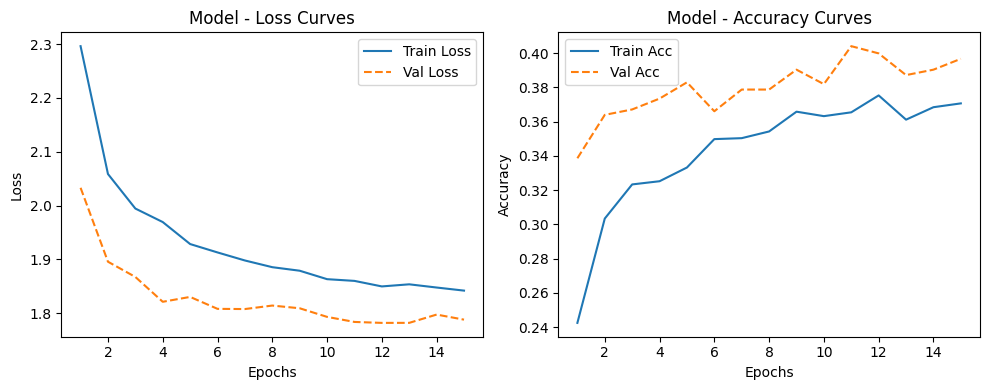


[TRAINING] Model=GIN, ArchID=init2
 Config: {'hidden_dim': 32, 'num_layers': 4, 'dropout': 0.006632480579933264}
Epoch 01: TrainLoss=2.1475, ValLoss=1.9261, TrainAcc=0.2885, ValAcc=0.3376
Epoch 02: TrainLoss=1.9204, ValLoss=1.8546, TrainAcc=0.3462, ValAcc=0.3681
Epoch 03: TrainLoss=1.8560, ValLoss=1.8287, TrainAcc=0.3671, ValAcc=0.3787
Epoch 04: TrainLoss=1.8221, ValLoss=1.8139, TrainAcc=0.3870, ValAcc=0.3797
Epoch 05: TrainLoss=1.8051, ValLoss=1.7918, TrainAcc=0.3866, ValAcc=0.3956
Epoch 06: TrainLoss=1.7804, ValLoss=1.7747, TrainAcc=0.3995, ValAcc=0.4072
Epoch 07: TrainLoss=1.7549, ValLoss=1.7822, TrainAcc=0.4051, ValAcc=0.4051
Epoch 08: TrainLoss=1.7528, ValLoss=1.7667, TrainAcc=0.4066, ValAcc=0.4167
Epoch 09: TrainLoss=1.7520, ValLoss=1.7640, TrainAcc=0.4099, ValAcc=0.3998
Epoch 10: TrainLoss=1.7482, ValLoss=1.7775, TrainAcc=0.4077, ValAcc=0.4103
Epoch 11: TrainLoss=1.7309, ValLoss=1.7649, TrainAcc=0.4201, ValAcc=0.4124
Epoch 12: TrainLoss=1.7311, ValLoss=1.7514, TrainAcc=0.4106, 

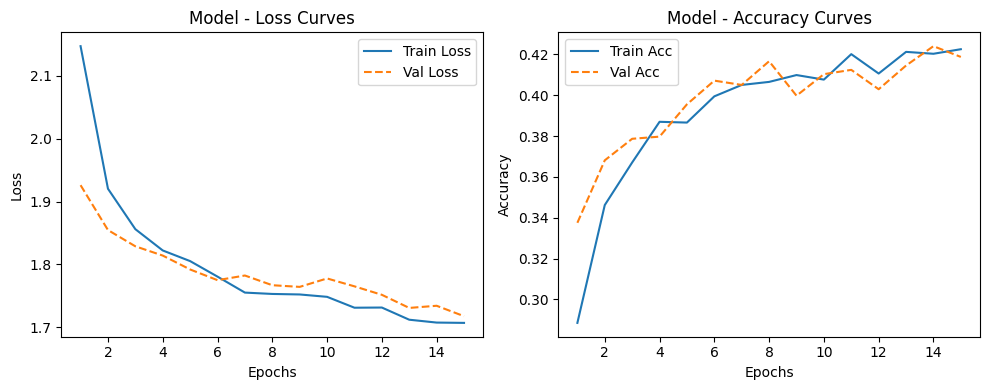


[TRAINING] Model=GIN, ArchID=init3
 Config: {'hidden_dim': 32, 'num_layers': 5, 'dropout': 0.28164410892276964}
Epoch 01: TrainLoss=2.2936, ValLoss=2.0026, TrainAcc=0.2195, ValAcc=0.3091
Epoch 02: TrainLoss=2.0724, ValLoss=1.9818, TrainAcc=0.2917, ValAcc=0.3323
Epoch 03: TrainLoss=2.0130, ValLoss=1.8891, TrainAcc=0.3090, ValAcc=0.3650
Epoch 04: TrainLoss=1.9843, ValLoss=1.8602, TrainAcc=0.3172, ValAcc=0.3671
Epoch 05: TrainLoss=1.9424, ValLoss=1.8497, TrainAcc=0.3297, ValAcc=0.3618
Epoch 06: TrainLoss=1.9477, ValLoss=1.8443, TrainAcc=0.3310, ValAcc=0.3745
Epoch 07: TrainLoss=1.9283, ValLoss=1.8583, TrainAcc=0.3416, ValAcc=0.3565
Epoch 08: TrainLoss=1.9147, ValLoss=1.8411, TrainAcc=0.3442, ValAcc=0.3660
Epoch 09: TrainLoss=1.9089, ValLoss=1.8200, TrainAcc=0.3487, ValAcc=0.3629
Epoch 10: TrainLoss=1.8947, ValLoss=1.8190, TrainAcc=0.3464, ValAcc=0.3829
Epoch 11: TrainLoss=1.8893, ValLoss=1.8226, TrainAcc=0.3440, ValAcc=0.3692
Epoch 12: TrainLoss=1.8800, ValLoss=1.8507, TrainAcc=0.3548, V

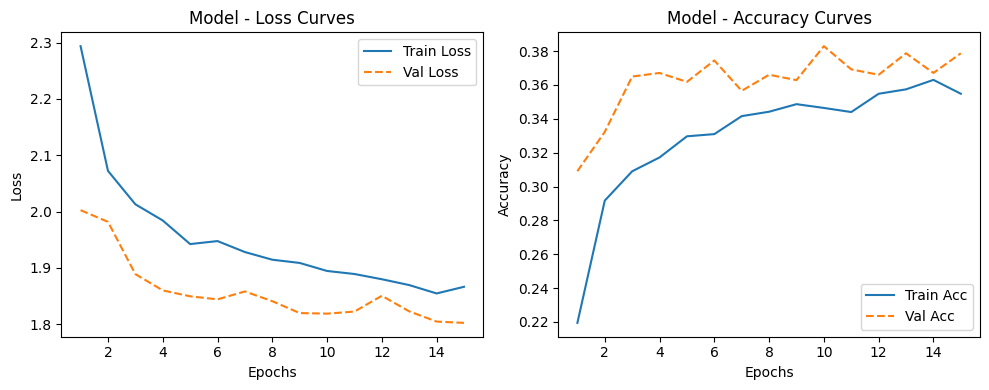


[TRAINING] Model=GIN, ArchID=iter1
 Config: {'hidden_dim': 128, 'num_layers': 4, 'dropout': 0.006632480579933264}
Epoch 01: TrainLoss=1.9942, ValLoss=1.9473, TrainAcc=0.3259, ValAcc=0.3534
Epoch 02: TrainLoss=1.8860, ValLoss=1.8207, TrainAcc=0.3582, ValAcc=0.3650
Epoch 03: TrainLoss=1.8299, ValLoss=1.8477, TrainAcc=0.3792, ValAcc=0.3945
Epoch 04: TrainLoss=1.8020, ValLoss=1.8528, TrainAcc=0.3920, ValAcc=0.3681
Epoch 05: TrainLoss=1.7880, ValLoss=1.7789, TrainAcc=0.3870, ValAcc=0.4030
Epoch 06: TrainLoss=1.7709, ValLoss=1.7580, TrainAcc=0.3931, ValAcc=0.3987
Epoch 07: TrainLoss=1.7585, ValLoss=1.7687, TrainAcc=0.3965, ValAcc=0.4019
Epoch 08: TrainLoss=1.7520, ValLoss=1.7662, TrainAcc=0.4047, ValAcc=0.4082
Epoch 09: TrainLoss=1.7396, ValLoss=1.7614, TrainAcc=0.4090, ValAcc=0.4061
Epoch 10: TrainLoss=1.7203, ValLoss=1.7452, TrainAcc=0.4147, ValAcc=0.4167
Epoch 11: TrainLoss=1.7219, ValLoss=1.7290, TrainAcc=0.4149, ValAcc=0.4051
Epoch 12: TrainLoss=1.7089, ValLoss=1.8083, TrainAcc=0.4198,

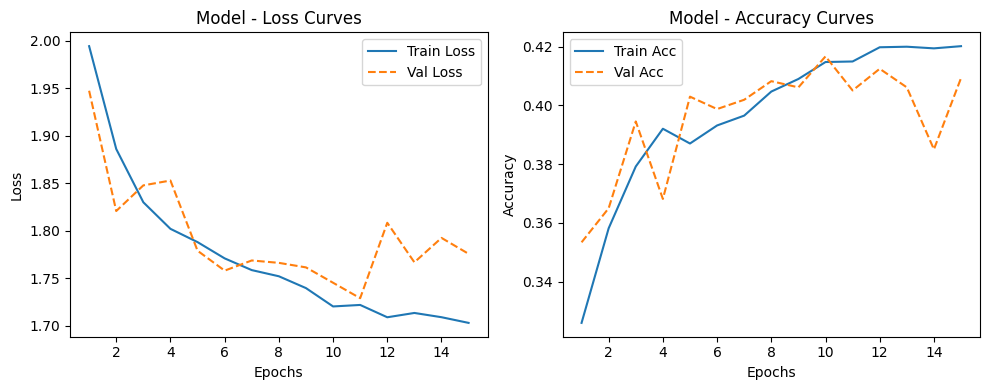

[GIN] Iter 1/6 | New Arch {'hidden_dim': 128, 'num_layers': 4, 'dropout': 0.006632480579933264} -> ValAcc=0.4167

[TRAINING] Model=GIN, ArchID=iter2
 Config: {'hidden_dim': 128, 'num_layers': 5, 'dropout': 0.006632480579933264}
Epoch 01: TrainLoss=2.0341, ValLoss=1.9174, TrainAcc=0.3003, ValAcc=0.3312
Epoch 02: TrainLoss=1.9185, ValLoss=1.8703, TrainAcc=0.3496, ValAcc=0.3692
Epoch 03: TrainLoss=1.8872, ValLoss=1.8455, TrainAcc=0.3637, ValAcc=0.3576
Epoch 04: TrainLoss=1.8500, ValLoss=1.8070, TrainAcc=0.3680, ValAcc=0.3914
Epoch 05: TrainLoss=1.8320, ValLoss=1.8632, TrainAcc=0.3810, ValAcc=0.3660
Epoch 06: TrainLoss=1.7933, ValLoss=1.8218, TrainAcc=0.3909, ValAcc=0.3892
Epoch 07: TrainLoss=1.7948, ValLoss=1.8166, TrainAcc=0.4000, ValAcc=0.3924
Epoch 08: TrainLoss=1.7894, ValLoss=1.8799, TrainAcc=0.3956, ValAcc=0.3608
Epoch 09: TrainLoss=1.7688, ValLoss=1.7711, TrainAcc=0.4015, ValAcc=0.4124
Epoch 10: TrainLoss=1.7646, ValLoss=1.7698, TrainAcc=0.4012, ValAcc=0.3987
Epoch 11: TrainLoss=1.

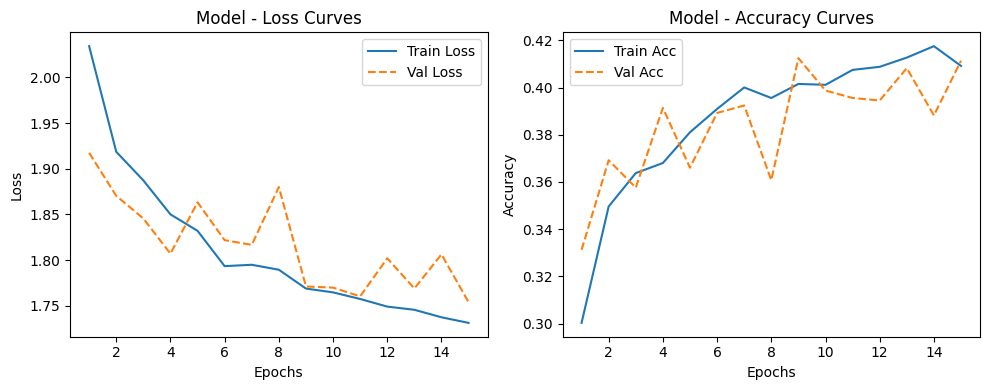

[GIN] Iter 2/6 | New Arch {'hidden_dim': 128, 'num_layers': 5, 'dropout': 0.006632480579933264} -> ValAcc=0.4124

[TRAINING] Model=GIN, ArchID=iter3
 Config: {'hidden_dim': 128, 'num_layers': 5, 'dropout': 0.3986476828897768}
Epoch 01: TrainLoss=2.1403, ValLoss=1.9347, TrainAcc=0.2500, ValAcc=0.3354
Epoch 02: TrainLoss=1.9865, ValLoss=1.8537, TrainAcc=0.3189, ValAcc=0.3629
Epoch 03: TrainLoss=1.9291, ValLoss=1.8518, TrainAcc=0.3299, ValAcc=0.3681
Epoch 04: TrainLoss=1.9160, ValLoss=1.8740, TrainAcc=0.3367, ValAcc=0.3565
Epoch 05: TrainLoss=1.8833, ValLoss=1.8091, TrainAcc=0.3542, ValAcc=0.4008
Epoch 06: TrainLoss=1.8748, ValLoss=1.8242, TrainAcc=0.3624, ValAcc=0.3745
Epoch 07: TrainLoss=1.8457, ValLoss=1.8456, TrainAcc=0.3755, ValAcc=0.3808
Epoch 08: TrainLoss=1.8417, ValLoss=1.7792, TrainAcc=0.3734, ValAcc=0.3987
Epoch 09: TrainLoss=1.8356, ValLoss=1.7655, TrainAcc=0.3740, ValAcc=0.3903
Epoch 10: TrainLoss=1.8186, ValLoss=1.7649, TrainAcc=0.3851, ValAcc=0.3966
Epoch 11: TrainLoss=1.81

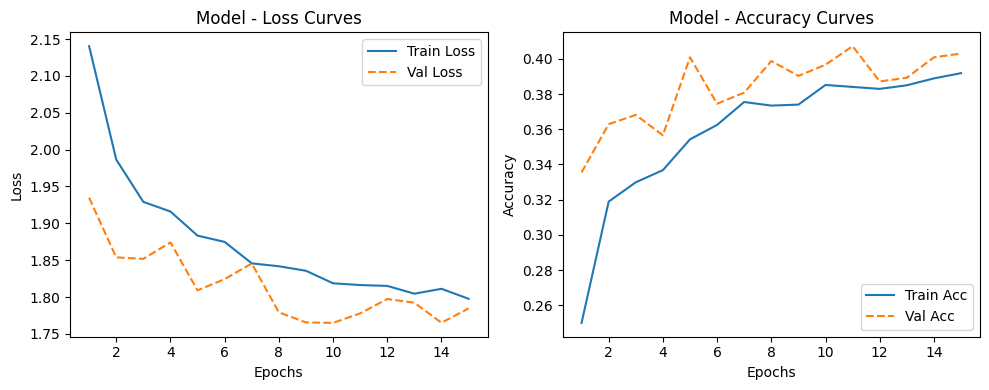

[GIN] Iter 3/6 | New Arch {'hidden_dim': 128, 'num_layers': 5, 'dropout': 0.3986476828897768} -> ValAcc=0.4072

[TRAINING] Model=GIN, ArchID=iter4
 Config: {'hidden_dim': 128, 'num_layers': 5, 'dropout': 0.006632480579933264}
Epoch 01: TrainLoss=2.0380, ValLoss=1.9408, TrainAcc=0.3058, ValAcc=0.3101
Epoch 02: TrainLoss=1.9042, ValLoss=1.8697, TrainAcc=0.3470, ValAcc=0.3481
Epoch 03: TrainLoss=1.8746, ValLoss=1.8232, TrainAcc=0.3608, ValAcc=0.3850
Epoch 04: TrainLoss=1.8374, ValLoss=1.8183, TrainAcc=0.3788, ValAcc=0.3713
Epoch 05: TrainLoss=1.8153, ValLoss=1.8182, TrainAcc=0.3945, ValAcc=0.3861
Epoch 06: TrainLoss=1.8028, ValLoss=1.7816, TrainAcc=0.3866, ValAcc=0.3998
Epoch 07: TrainLoss=1.7794, ValLoss=1.7988, TrainAcc=0.3913, ValAcc=0.4093
Epoch 08: TrainLoss=1.7777, ValLoss=1.8134, TrainAcc=0.4019, ValAcc=0.3819
Epoch 09: TrainLoss=1.7663, ValLoss=1.7933, TrainAcc=0.3982, ValAcc=0.4030
Epoch 10: TrainLoss=1.7680, ValLoss=1.7843, TrainAcc=0.4062, ValAcc=0.4061
Epoch 11: TrainLoss=1.75

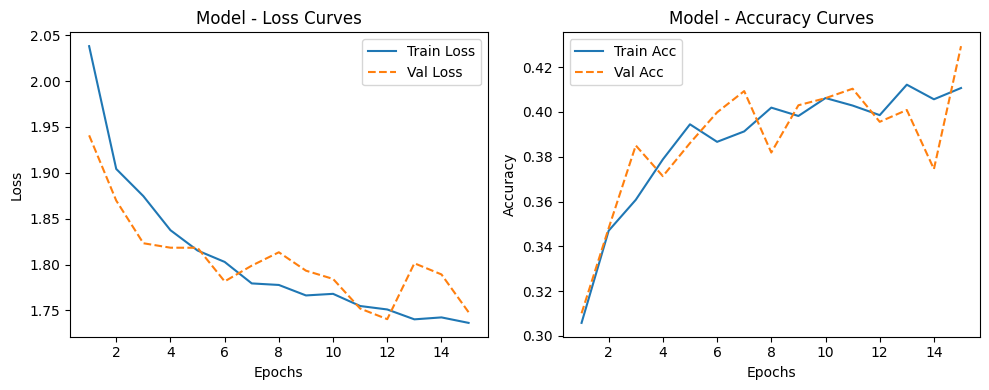

[GIN] Iter 4/6 | New Arch {'hidden_dim': 128, 'num_layers': 5, 'dropout': 0.006632480579933264} -> ValAcc=0.4293

[TRAINING] Model=GIN, ArchID=iter5
 Config: {'hidden_dim': 128, 'num_layers': 5, 'dropout': 0.06161132708608302}
Epoch 01: TrainLoss=2.0888, ValLoss=1.9901, TrainAcc=0.2848, ValAcc=0.3112
Epoch 02: TrainLoss=1.9449, ValLoss=2.0946, TrainAcc=0.3287, ValAcc=0.2753
Epoch 03: TrainLoss=1.9024, ValLoss=1.8380, TrainAcc=0.3533, ValAcc=0.3903
Epoch 04: TrainLoss=1.8585, ValLoss=1.8597, TrainAcc=0.3688, ValAcc=0.3724
Epoch 05: TrainLoss=1.8320, ValLoss=1.8166, TrainAcc=0.3790, ValAcc=0.3724
Epoch 06: TrainLoss=1.8231, ValLoss=1.8015, TrainAcc=0.3833, ValAcc=0.3966
Epoch 07: TrainLoss=1.8089, ValLoss=1.7972, TrainAcc=0.3866, ValAcc=0.3892
Epoch 08: TrainLoss=1.8024, ValLoss=1.7866, TrainAcc=0.3874, ValAcc=0.3724
Epoch 09: TrainLoss=1.7846, ValLoss=1.7848, TrainAcc=0.3881, ValAcc=0.3956
Epoch 10: TrainLoss=1.7802, ValLoss=1.7797, TrainAcc=0.4004, ValAcc=0.4061
Epoch 11: TrainLoss=1.7

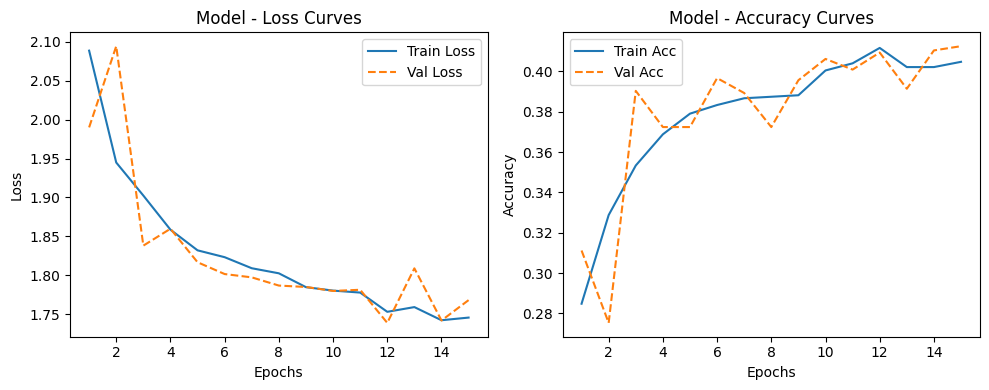

[GIN] Iter 5/6 | New Arch {'hidden_dim': 128, 'num_layers': 5, 'dropout': 0.06161132708608302} -> ValAcc=0.4124

[TRAINING] Model=GIN, ArchID=iter6
 Config: {'hidden_dim': 128, 'num_layers': 5, 'dropout': 0.3986476828897768}
Epoch 01: TrainLoss=2.1432, ValLoss=1.9119, TrainAcc=0.2641, ValAcc=0.3470
Epoch 02: TrainLoss=1.9909, ValLoss=1.8843, TrainAcc=0.3263, ValAcc=0.3639
Epoch 03: TrainLoss=1.9324, ValLoss=1.8492, TrainAcc=0.3481, ValAcc=0.3703
Epoch 04: TrainLoss=1.9133, ValLoss=1.8245, TrainAcc=0.3468, ValAcc=0.3850
Epoch 05: TrainLoss=1.8991, ValLoss=1.8468, TrainAcc=0.3559, ValAcc=0.3734
Epoch 06: TrainLoss=1.8830, ValLoss=1.8098, TrainAcc=0.3608, ValAcc=0.3829
Epoch 07: TrainLoss=1.8577, ValLoss=1.8494, TrainAcc=0.3678, ValAcc=0.3724
Epoch 08: TrainLoss=1.8609, ValLoss=1.8177, TrainAcc=0.3712, ValAcc=0.3755
Epoch 09: TrainLoss=1.8472, ValLoss=1.7954, TrainAcc=0.3749, ValAcc=0.3861
Epoch 10: TrainLoss=1.8321, ValLoss=1.8539, TrainAcc=0.3743, ValAcc=0.3914
Epoch 11: TrainLoss=1.838

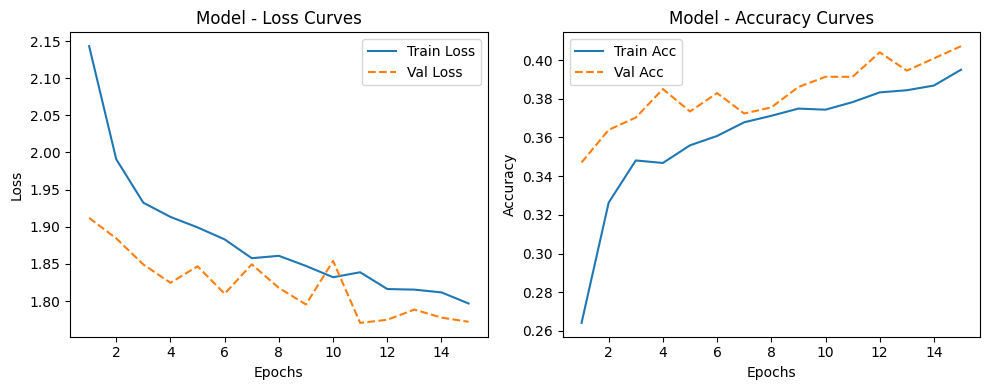

[GIN] Iter 6/6 | New Arch {'hidden_dim': 128, 'num_layers': 5, 'dropout': 0.3986476828897768} -> ValAcc=0.4072

=== Best GIN Architecture ===
{'hidden_dim': np.float32(128.0), 'num_layers': np.float32(5.0), 'dropout': np.float32(0.006632481)} Validation Accuracy: 0.4293

===== BANANAS SEARCH for GAT =====

[TRAINING] Model=GAT, ArchID=init1
 Config: {'hidden_dim': 64, 'num_layers': 4, 'dropout': 0.10632218818554806, 'num_heads': 8}
Epoch 01: TrainLoss=2.1942, ValLoss=1.9771, TrainAcc=0.2483, ValAcc=0.3217
Epoch 02: TrainLoss=2.0334, ValLoss=1.9848, TrainAcc=0.3016, ValAcc=0.3323
Epoch 03: TrainLoss=1.9808, ValLoss=1.8924, TrainAcc=0.3215, ValAcc=0.3502
Epoch 04: TrainLoss=1.9508, ValLoss=1.8784, TrainAcc=0.3261, ValAcc=0.3734
Epoch 05: TrainLoss=1.9215, ValLoss=1.8774, TrainAcc=0.3338, ValAcc=0.3608
Epoch 06: TrainLoss=1.9074, ValLoss=1.9291, TrainAcc=0.3513, ValAcc=0.3449
Epoch 07: TrainLoss=1.8977, ValLoss=1.8996, TrainAcc=0.3524, ValAcc=0.3481
Epoch 08: TrainLoss=1.8810, ValLoss=1.8

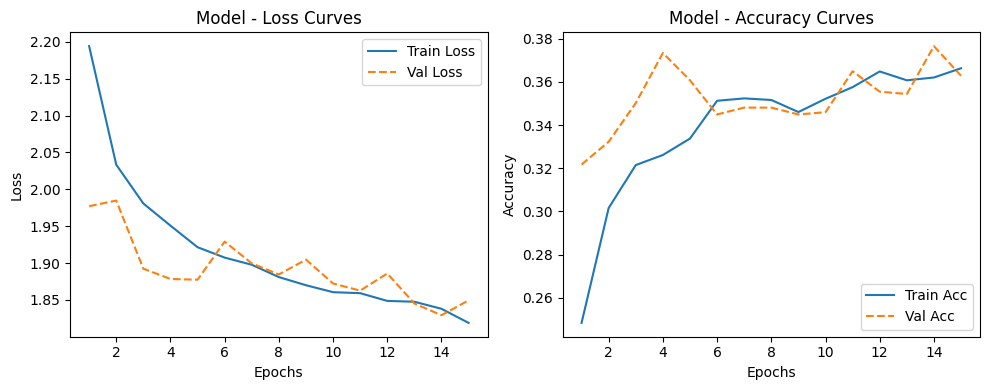


[TRAINING] Model=GAT, ArchID=init2
 Config: {'hidden_dim': 32, 'num_layers': 2, 'dropout': 0.20415317137972555, 'num_heads': 4}
Epoch 01: TrainLoss=2.3937, ValLoss=2.1925, TrainAcc=0.1828, ValAcc=0.2616
Epoch 02: TrainLoss=2.2212, ValLoss=2.1064, TrainAcc=0.2483, ValAcc=0.2996
Epoch 03: TrainLoss=2.1850, ValLoss=2.0800, TrainAcc=0.2645, ValAcc=0.3027
Epoch 04: TrainLoss=2.1576, ValLoss=2.0540, TrainAcc=0.2675, ValAcc=0.3207
Epoch 05: TrainLoss=2.1185, ValLoss=2.0291, TrainAcc=0.2880, ValAcc=0.3122
Epoch 06: TrainLoss=2.1028, ValLoss=2.0077, TrainAcc=0.2822, ValAcc=0.3291
Epoch 07: TrainLoss=2.0941, ValLoss=2.0018, TrainAcc=0.2885, ValAcc=0.3259
Epoch 08: TrainLoss=2.0825, ValLoss=1.9909, TrainAcc=0.2939, ValAcc=0.3428
Epoch 09: TrainLoss=2.0535, ValLoss=2.0165, TrainAcc=0.2975, ValAcc=0.3344
Epoch 10: TrainLoss=2.0594, ValLoss=2.0166, TrainAcc=0.3025, ValAcc=0.3259
Epoch 11: TrainLoss=2.0473, ValLoss=1.9930, TrainAcc=0.2977, ValAcc=0.3344
Epoch 12: TrainLoss=2.0493, ValLoss=2.0565, Tr

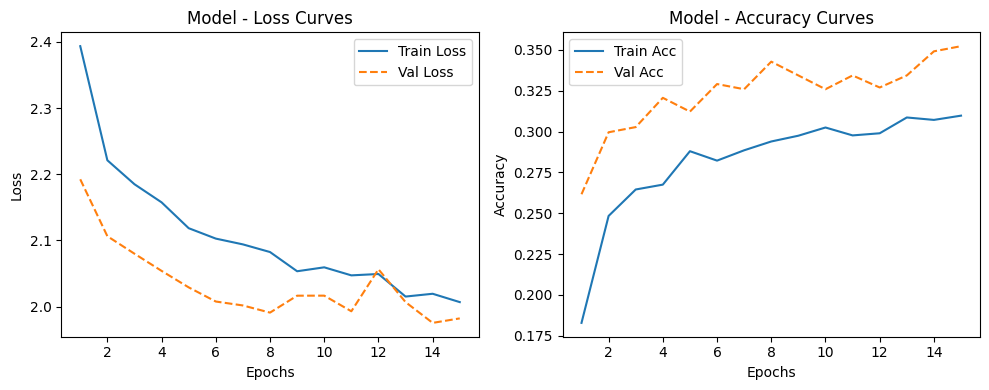


[TRAINING] Model=GAT, ArchID=init3
 Config: {'hidden_dim': 32, 'num_layers': 4, 'dropout': 0.40369801516997567, 'num_heads': 2}
Epoch 01: TrainLoss=2.9183, ValLoss=2.5675, TrainAcc=0.0743, ValAcc=0.0675
Epoch 02: TrainLoss=2.6410, ValLoss=2.5580, TrainAcc=0.0821, ValAcc=0.0960
Epoch 03: TrainLoss=2.5917, ValLoss=2.5505, TrainAcc=0.0894, ValAcc=0.1086
Epoch 04: TrainLoss=2.5724, ValLoss=2.5524, TrainAcc=0.0957, ValAcc=0.1160
Epoch 05: TrainLoss=2.5552, ValLoss=2.5482, TrainAcc=0.1031, ValAcc=0.0981
Epoch 06: TrainLoss=2.5323, ValLoss=2.5245, TrainAcc=0.1149, ValAcc=0.0844
Epoch 07: TrainLoss=2.5170, ValLoss=2.5040, TrainAcc=0.1128, ValAcc=0.0791
Epoch 08: TrainLoss=2.5007, ValLoss=2.4768, TrainAcc=0.1234, ValAcc=0.0770
Epoch 09: TrainLoss=2.4710, ValLoss=2.4453, TrainAcc=0.1342, ValAcc=0.0854
Epoch 10: TrainLoss=2.4457, ValLoss=2.4338, TrainAcc=0.1539, ValAcc=0.1002
Epoch 11: TrainLoss=2.4351, ValLoss=2.4334, TrainAcc=0.1512, ValAcc=0.1044
Epoch 12: TrainLoss=2.4099, ValLoss=2.4040, Tr

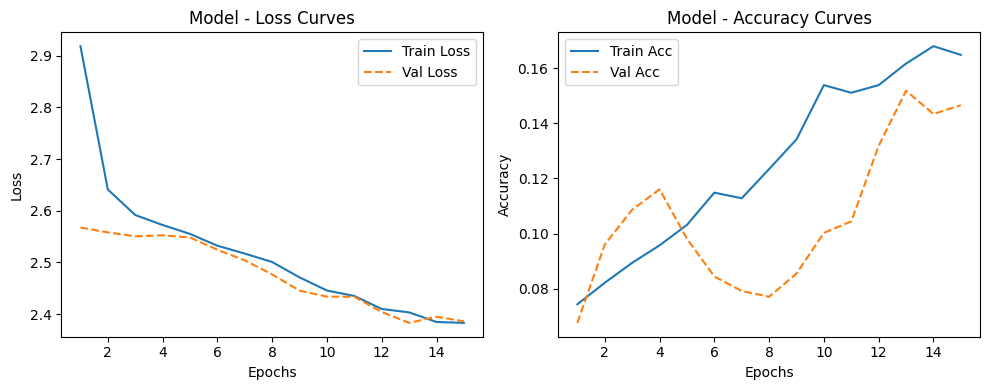


[TRAINING] Model=GAT, ArchID=iter1
 Config: {'hidden_dim': 128, 'num_layers': 4, 'dropout': 0.10632218818554806, 'num_heads': 8}
Epoch 01: TrainLoss=2.1289, ValLoss=1.9432, TrainAcc=0.2744, ValAcc=0.3238
Epoch 02: TrainLoss=1.9839, ValLoss=1.8829, TrainAcc=0.3157, ValAcc=0.3502
Epoch 03: TrainLoss=1.9411, ValLoss=1.8906, TrainAcc=0.3274, ValAcc=0.3502
Epoch 04: TrainLoss=1.9087, ValLoss=1.9057, TrainAcc=0.3360, ValAcc=0.3492
Epoch 05: TrainLoss=1.8842, ValLoss=1.8754, TrainAcc=0.3492, ValAcc=0.3745
Epoch 06: TrainLoss=1.8903, ValLoss=1.8390, TrainAcc=0.3485, ValAcc=0.3681
Epoch 07: TrainLoss=1.8580, ValLoss=1.8287, TrainAcc=0.3546, ValAcc=0.3660
Epoch 08: TrainLoss=1.8437, ValLoss=1.9333, TrainAcc=0.3561, ValAcc=0.3397
Epoch 09: TrainLoss=1.8446, ValLoss=1.8780, TrainAcc=0.3639, ValAcc=0.3650
Epoch 10: TrainLoss=1.8282, ValLoss=1.8195, TrainAcc=0.3528, ValAcc=0.3850
Epoch 11: TrainLoss=1.8343, ValLoss=1.9172, TrainAcc=0.3676, ValAcc=0.3565
Epoch 12: TrainLoss=1.8177, ValLoss=1.8368, T

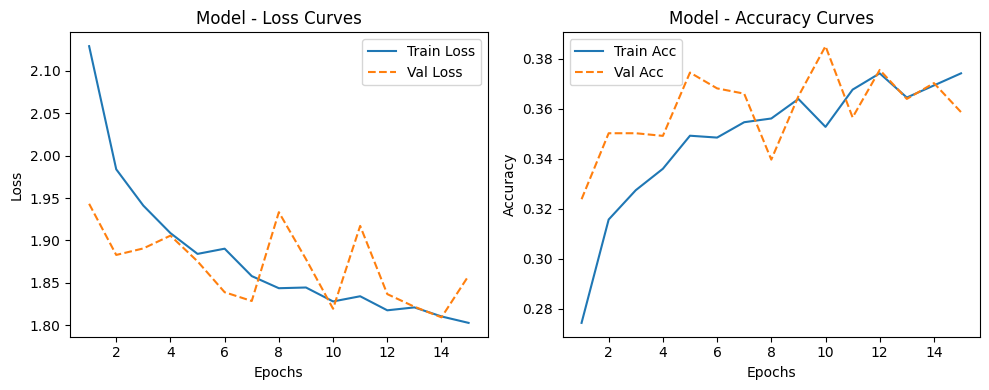

[GAT] Iter 1/6 | New Arch {'hidden_dim': 128, 'num_layers': 4, 'dropout': 0.10632218818554806, 'num_heads': 8} -> ValAcc=0.3850

[TRAINING] Model=GAT, ArchID=iter2
 Config: {'hidden_dim': 64, 'num_layers': 4, 'dropout': 0.10632218818554806, 'num_heads': 8}
Epoch 01: TrainLoss=2.1852, ValLoss=1.9807, TrainAcc=0.2465, ValAcc=0.3080
Epoch 02: TrainLoss=2.0294, ValLoss=1.9136, TrainAcc=0.2995, ValAcc=0.3470
Epoch 03: TrainLoss=1.9685, ValLoss=1.9223, TrainAcc=0.3112, ValAcc=0.3397
Epoch 04: TrainLoss=1.9297, ValLoss=1.8882, TrainAcc=0.3252, ValAcc=0.3513
Epoch 05: TrainLoss=1.9185, ValLoss=1.8956, TrainAcc=0.3280, ValAcc=0.3513
Epoch 06: TrainLoss=1.9013, ValLoss=1.8810, TrainAcc=0.3416, ValAcc=0.3534
Epoch 07: TrainLoss=1.8801, ValLoss=1.9182, TrainAcc=0.3548, ValAcc=0.3323
Epoch 08: TrainLoss=1.8703, ValLoss=1.9077, TrainAcc=0.3490, ValAcc=0.3513
Epoch 09: TrainLoss=1.8678, ValLoss=1.8958, TrainAcc=0.3440, ValAcc=0.3365
Epoch 10: TrainLoss=1.8607, ValLoss=1.8806, TrainAcc=0.3544, ValAcc=

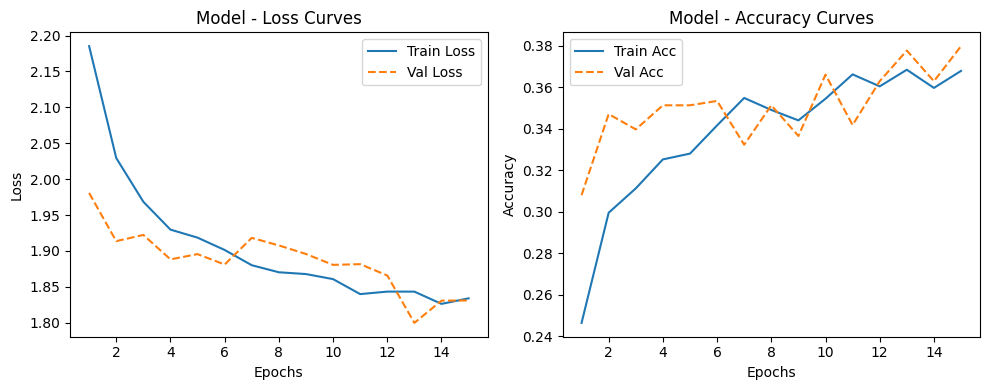

[GAT] Iter 2/6 | New Arch {'hidden_dim': 64, 'num_layers': 4, 'dropout': 0.10632218818554806, 'num_heads': 8} -> ValAcc=0.3797

[TRAINING] Model=GAT, ArchID=iter3
 Config: {'hidden_dim': 64, 'num_layers': 4, 'dropout': 0.022701640734346273, 'num_heads': 8}
Epoch 01: TrainLoss=2.0652, ValLoss=1.8981, TrainAcc=0.2969, ValAcc=0.3281
Epoch 02: TrainLoss=1.8853, ValLoss=1.8735, TrainAcc=0.3487, ValAcc=0.3376
Epoch 03: TrainLoss=1.8407, ValLoss=1.8414, TrainAcc=0.3678, ValAcc=0.3639
Epoch 04: TrainLoss=1.8076, ValLoss=1.8611, TrainAcc=0.3729, ValAcc=0.3544
Epoch 05: TrainLoss=1.7962, ValLoss=1.8387, TrainAcc=0.3770, ValAcc=0.3819
Epoch 06: TrainLoss=1.7823, ValLoss=1.8218, TrainAcc=0.3904, ValAcc=0.3639
Epoch 07: TrainLoss=1.7736, ValLoss=1.7968, TrainAcc=0.3883, ValAcc=0.3713
Epoch 08: TrainLoss=1.7609, ValLoss=1.7961, TrainAcc=0.3892, ValAcc=0.3840
Epoch 09: TrainLoss=1.7455, ValLoss=1.7956, TrainAcc=0.4000, ValAcc=0.3724
Epoch 10: TrainLoss=1.7391, ValLoss=1.7962, TrainAcc=0.3917, ValAcc=

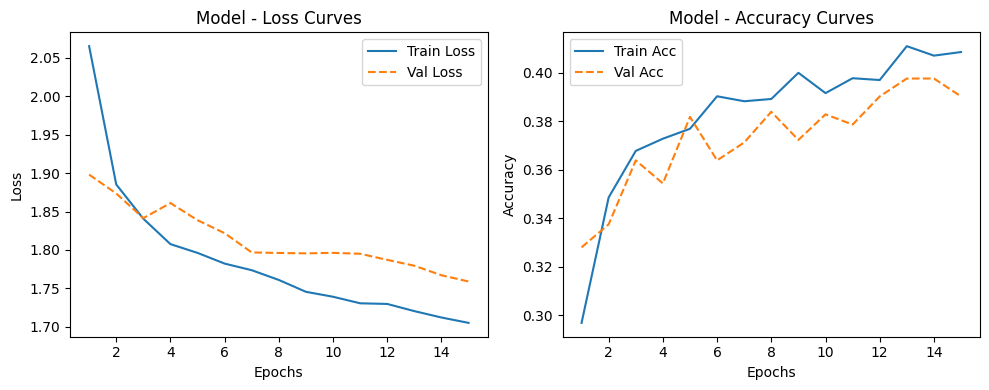

[GAT] Iter 3/6 | New Arch {'hidden_dim': 64, 'num_layers': 4, 'dropout': 0.022701640734346273, 'num_heads': 8} -> ValAcc=0.3977

[TRAINING] Model=GAT, ArchID=iter4
 Config: {'hidden_dim': 64, 'num_layers': 4, 'dropout': 0.11577421798252441, 'num_heads': 8}
Epoch 01: TrainLoss=2.2096, ValLoss=2.0039, TrainAcc=0.2513, ValAcc=0.3186
Epoch 02: TrainLoss=2.0433, ValLoss=1.9305, TrainAcc=0.2999, ValAcc=0.3386
Epoch 03: TrainLoss=1.9833, ValLoss=1.9249, TrainAcc=0.3165, ValAcc=0.3449
Epoch 04: TrainLoss=1.9485, ValLoss=1.9720, TrainAcc=0.3327, ValAcc=0.3376
Epoch 05: TrainLoss=1.9292, ValLoss=1.8930, TrainAcc=0.3252, ValAcc=0.3513
Epoch 06: TrainLoss=1.9163, ValLoss=1.8552, TrainAcc=0.3380, ValAcc=0.3576
Epoch 07: TrainLoss=1.9098, ValLoss=1.8723, TrainAcc=0.3399, ValAcc=0.3576
Epoch 08: TrainLoss=1.8803, ValLoss=1.8279, TrainAcc=0.3433, ValAcc=0.3639
Epoch 09: TrainLoss=1.8788, ValLoss=1.8526, TrainAcc=0.3481, ValAcc=0.3629
Epoch 10: TrainLoss=1.8810, ValLoss=1.8417, TrainAcc=0.3433, ValAcc=

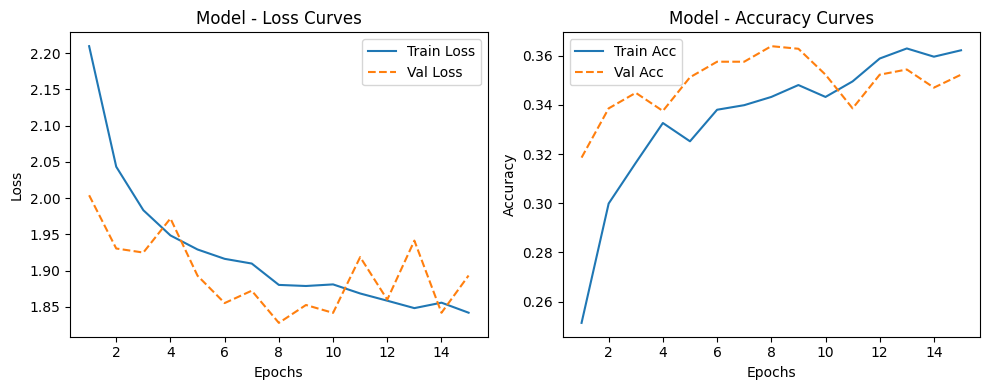

[GAT] Iter 4/6 | New Arch {'hidden_dim': 64, 'num_layers': 4, 'dropout': 0.11577421798252441, 'num_heads': 8} -> ValAcc=0.3639

[TRAINING] Model=GAT, ArchID=iter5
 Config: {'hidden_dim': 32, 'num_layers': 2, 'dropout': 0.20415317137972555, 'num_heads': 8}
Epoch 01: TrainLoss=2.3914, ValLoss=2.1730, TrainAcc=0.1815, ValAcc=0.2637
Epoch 02: TrainLoss=2.2232, ValLoss=2.0911, TrainAcc=0.2455, ValAcc=0.2964
Epoch 03: TrainLoss=2.1789, ValLoss=2.0573, TrainAcc=0.2638, ValAcc=0.3006
Epoch 04: TrainLoss=2.1386, ValLoss=2.0328, TrainAcc=0.2740, ValAcc=0.3133
Epoch 05: TrainLoss=2.1232, ValLoss=2.0214, TrainAcc=0.2790, ValAcc=0.3059
Epoch 06: TrainLoss=2.0939, ValLoss=1.9954, TrainAcc=0.2792, ValAcc=0.3228
Epoch 07: TrainLoss=2.0781, ValLoss=2.0035, TrainAcc=0.2911, ValAcc=0.3133
Epoch 08: TrainLoss=2.0498, ValLoss=1.9835, TrainAcc=0.2952, ValAcc=0.3143
Epoch 09: TrainLoss=2.0401, ValLoss=1.9990, TrainAcc=0.3058, ValAcc=0.3133
Epoch 10: TrainLoss=2.0315, ValLoss=1.9817, TrainAcc=0.3008, ValAcc=0

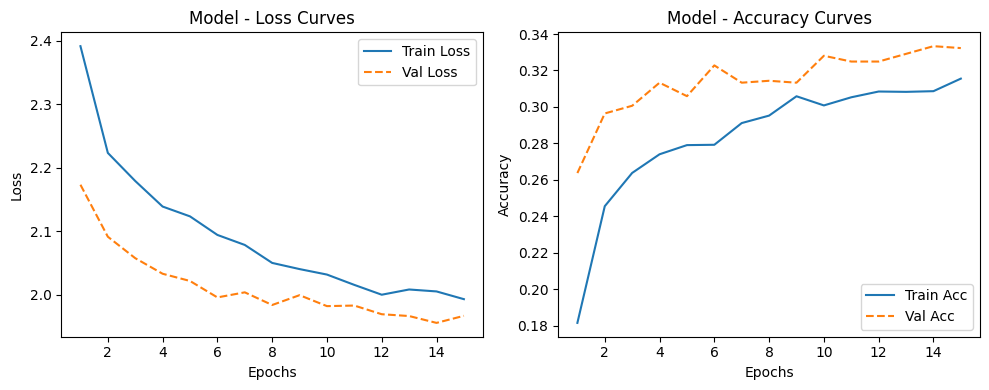

[GAT] Iter 5/6 | New Arch {'hidden_dim': 32, 'num_layers': 2, 'dropout': 0.20415317137972555, 'num_heads': 8} -> ValAcc=0.3333

[TRAINING] Model=GAT, ArchID=iter6
 Config: {'hidden_dim': 64, 'num_layers': 4, 'dropout': 0.02012900150461605, 'num_heads': 8}
Epoch 01: TrainLoss=2.0709, ValLoss=1.8960, TrainAcc=0.3003, ValAcc=0.3576
Epoch 02: TrainLoss=1.8795, ValLoss=1.8919, TrainAcc=0.3524, ValAcc=0.3428
Epoch 03: TrainLoss=1.8254, ValLoss=1.8247, TrainAcc=0.3734, ValAcc=0.3755
Epoch 04: TrainLoss=1.8025, ValLoss=1.8495, TrainAcc=0.3794, ValAcc=0.3565
Epoch 05: TrainLoss=1.7871, ValLoss=1.8271, TrainAcc=0.3827, ValAcc=0.3608
Epoch 06: TrainLoss=1.7713, ValLoss=1.8175, TrainAcc=0.3881, ValAcc=0.3692
Epoch 07: TrainLoss=1.7680, ValLoss=1.7980, TrainAcc=0.3896, ValAcc=0.3734
Epoch 08: TrainLoss=1.7434, ValLoss=1.7865, TrainAcc=0.4041, ValAcc=0.3766
Epoch 09: TrainLoss=1.7412, ValLoss=1.7919, TrainAcc=0.4019, ValAcc=0.3703
Epoch 10: TrainLoss=1.7355, ValLoss=1.7929, TrainAcc=0.3985, ValAcc=0

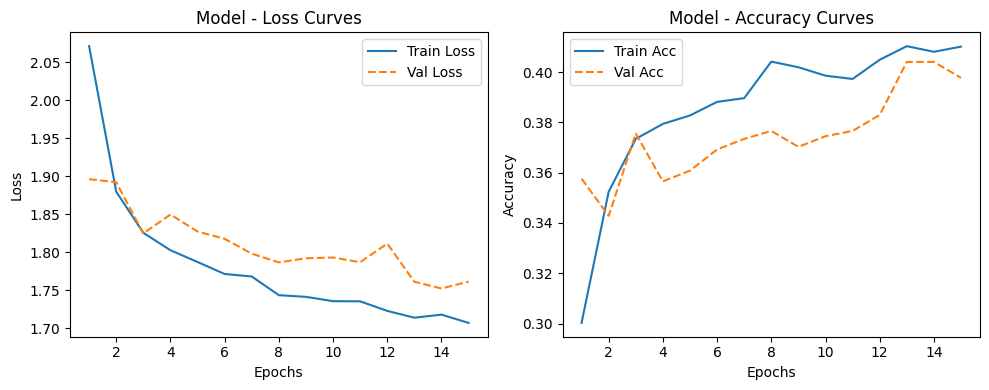

[GAT] Iter 6/6 | New Arch {'hidden_dim': 64, 'num_layers': 4, 'dropout': 0.02012900150461605, 'num_heads': 8} -> ValAcc=0.4040

=== Best GAT Architecture ===
{'hidden_dim': np.float32(64.0), 'num_layers': np.float32(4.0), 'dropout': np.float32(0.020129), 'num_heads': np.float32(8.0)} Validation Accuracy: 0.4040

===== BANANAS SEARCH for DiffPool =====

[TRAINING] Model=DiffPool, ArchID=init1
 Config: {'hidden_dim': 32, 'assign_dim': 16, 'embed_dim': 32}
Epoch 01: TrainLoss=2.4524, ValLoss=2.2331, TrainAcc=0.1547, ValAcc=0.2036
Epoch 02: TrainLoss=2.1644, ValLoss=2.0638, TrainAcc=0.2627, ValAcc=0.2975
Epoch 03: TrainLoss=2.0780, ValLoss=2.0002, TrainAcc=0.3008, ValAcc=0.3238
Epoch 04: TrainLoss=2.0265, ValLoss=1.9658, TrainAcc=0.3194, ValAcc=0.3217
Epoch 05: TrainLoss=2.0003, ValLoss=1.9373, TrainAcc=0.3269, ValAcc=0.3312
Epoch 06: TrainLoss=1.9745, ValLoss=1.9293, TrainAcc=0.3377, ValAcc=0.3312
Epoch 07: TrainLoss=1.9545, ValLoss=1.9062, TrainAcc=0.3394, ValAcc=0.3502
Epoch 08: TrainLo

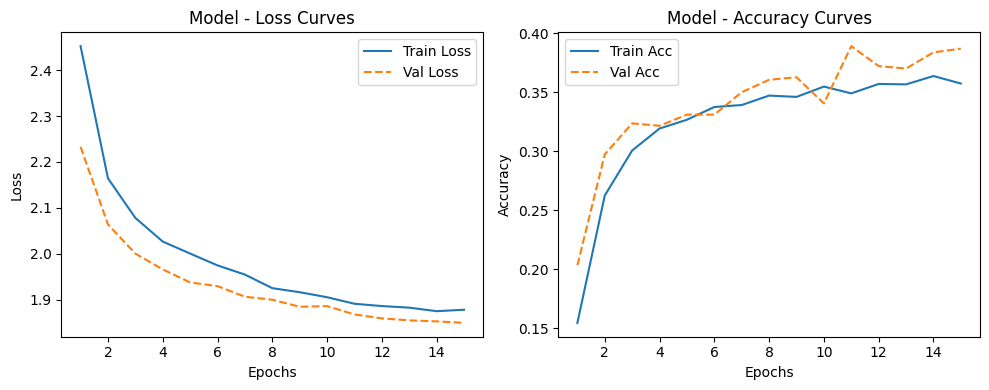


[TRAINING] Model=DiffPool, ArchID=init2
 Config: {'hidden_dim': 64, 'assign_dim': 4, 'embed_dim': 64}
Epoch 01: TrainLoss=2.3529, ValLoss=2.0964, TrainAcc=0.1975, ValAcc=0.2954
Epoch 02: TrainLoss=2.0746, ValLoss=1.9855, TrainAcc=0.3045, ValAcc=0.3122
Epoch 03: TrainLoss=1.9999, ValLoss=1.9578, TrainAcc=0.3235, ValAcc=0.3080
Epoch 04: TrainLoss=1.9429, ValLoss=1.8935, TrainAcc=0.3340, ValAcc=0.3418
Epoch 05: TrainLoss=1.9118, ValLoss=1.8793, TrainAcc=0.3468, ValAcc=0.3671
Epoch 06: TrainLoss=1.8889, ValLoss=1.8744, TrainAcc=0.3567, ValAcc=0.3565
Epoch 07: TrainLoss=1.8759, ValLoss=1.8706, TrainAcc=0.3522, ValAcc=0.3660
Epoch 08: TrainLoss=1.8649, ValLoss=1.8468, TrainAcc=0.3529, ValAcc=0.3724
Epoch 09: TrainLoss=1.8543, ValLoss=1.8540, TrainAcc=0.3611, ValAcc=0.3576
Epoch 10: TrainLoss=1.8430, ValLoss=1.8454, TrainAcc=0.3680, ValAcc=0.3681
Epoch 11: TrainLoss=1.8363, ValLoss=1.8359, TrainAcc=0.3708, ValAcc=0.3850
Epoch 12: TrainLoss=1.8203, ValLoss=1.8175, TrainAcc=0.3764, ValAcc=0.37

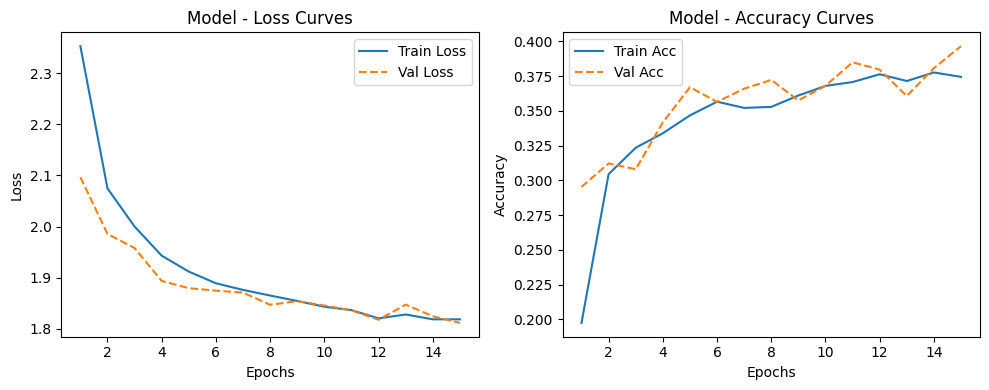


[TRAINING] Model=DiffPool, ArchID=init3
 Config: {'hidden_dim': 64, 'assign_dim': 8, 'embed_dim': 16}
Epoch 01: TrainLoss=2.4589, ValLoss=2.2641, TrainAcc=0.1480, ValAcc=0.2120
Epoch 02: TrainLoss=2.1877, ValLoss=2.0890, TrainAcc=0.2390, ValAcc=0.2595
Epoch 03: TrainLoss=2.0958, ValLoss=2.0315, TrainAcc=0.2684, ValAcc=0.2848
Epoch 04: TrainLoss=2.0499, ValLoss=1.9953, TrainAcc=0.2977, ValAcc=0.3228
Epoch 05: TrainLoss=2.0046, ValLoss=1.9706, TrainAcc=0.3226, ValAcc=0.3175
Epoch 06: TrainLoss=1.9681, ValLoss=1.9329, TrainAcc=0.3377, ValAcc=0.3270
Epoch 07: TrainLoss=1.9442, ValLoss=1.9069, TrainAcc=0.3379, ValAcc=0.3639
Epoch 08: TrainLoss=1.9181, ValLoss=1.8886, TrainAcc=0.3481, ValAcc=0.3449
Epoch 09: TrainLoss=1.8993, ValLoss=1.8874, TrainAcc=0.3414, ValAcc=0.3376
Epoch 10: TrainLoss=1.8779, ValLoss=1.8682, TrainAcc=0.3570, ValAcc=0.3492
Epoch 11: TrainLoss=1.8804, ValLoss=1.8579, TrainAcc=0.3563, ValAcc=0.3449
Epoch 12: TrainLoss=1.8751, ValLoss=1.8566, TrainAcc=0.3583, ValAcc=0.35

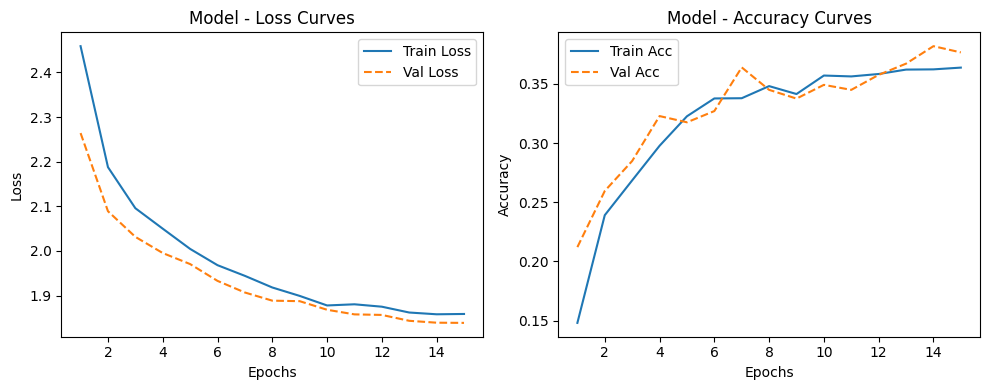


[TRAINING] Model=DiffPool, ArchID=iter1
 Config: {'hidden_dim': 128, 'assign_dim': 16, 'embed_dim': 32}
Epoch 01: TrainLoss=2.3946, ValLoss=2.1314, TrainAcc=0.1620, ValAcc=0.2785
Epoch 02: TrainLoss=2.0752, ValLoss=1.9908, TrainAcc=0.3060, ValAcc=0.3270
Epoch 03: TrainLoss=1.9828, ValLoss=1.9291, TrainAcc=0.3295, ValAcc=0.3492
Epoch 04: TrainLoss=1.9260, ValLoss=1.9003, TrainAcc=0.3455, ValAcc=0.3333
Epoch 05: TrainLoss=1.8890, ValLoss=1.8782, TrainAcc=0.3535, ValAcc=0.3492
Epoch 06: TrainLoss=1.8703, ValLoss=1.8818, TrainAcc=0.3541, ValAcc=0.3586
Epoch 07: TrainLoss=1.8518, ValLoss=1.8477, TrainAcc=0.3654, ValAcc=0.3544
Epoch 08: TrainLoss=1.8460, ValLoss=1.8433, TrainAcc=0.3649, ValAcc=0.3861
Epoch 09: TrainLoss=1.8287, ValLoss=1.8432, TrainAcc=0.3719, ValAcc=0.3734
Epoch 10: TrainLoss=1.8306, ValLoss=1.8449, TrainAcc=0.3768, ValAcc=0.3703
Epoch 11: TrainLoss=1.8219, ValLoss=1.8368, TrainAcc=0.3796, ValAcc=0.3650
Epoch 12: TrainLoss=1.8153, ValLoss=1.8258, TrainAcc=0.3781, ValAcc=0.

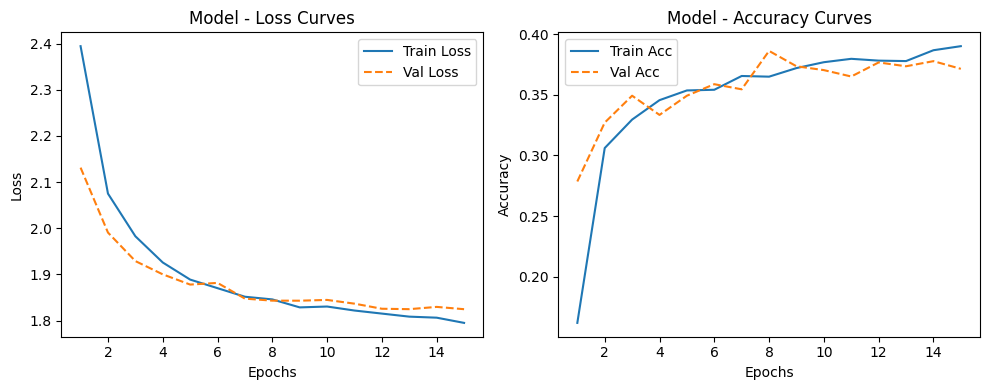

[DiffPool] Iter 1/6 | New Arch {'hidden_dim': 128, 'assign_dim': 16, 'embed_dim': 32} -> ValAcc=0.3861

[TRAINING] Model=DiffPool, ArchID=iter2
 Config: {'hidden_dim': 32, 'assign_dim': 4, 'embed_dim': 64}
Epoch 01: TrainLoss=2.4080, ValLoss=2.1607, TrainAcc=0.1787, ValAcc=0.2215
Epoch 02: TrainLoss=2.1235, ValLoss=2.0336, TrainAcc=0.2749, ValAcc=0.2985
Epoch 03: TrainLoss=2.0435, ValLoss=1.9742, TrainAcc=0.3079, ValAcc=0.3291
Epoch 04: TrainLoss=2.0028, ValLoss=1.9414, TrainAcc=0.3254, ValAcc=0.3270
Epoch 05: TrainLoss=1.9685, ValLoss=1.9147, TrainAcc=0.3287, ValAcc=0.3323
Epoch 06: TrainLoss=1.9435, ValLoss=1.9009, TrainAcc=0.3332, ValAcc=0.3745
Epoch 07: TrainLoss=1.9296, ValLoss=1.8956, TrainAcc=0.3442, ValAcc=0.3565
Epoch 08: TrainLoss=1.9102, ValLoss=1.8720, TrainAcc=0.3511, ValAcc=0.3713
Epoch 09: TrainLoss=1.9040, ValLoss=1.8679, TrainAcc=0.3542, ValAcc=0.3639
Epoch 10: TrainLoss=1.8918, ValLoss=1.8673, TrainAcc=0.3552, ValAcc=0.3660
Epoch 11: TrainLoss=1.8854, ValLoss=1.8554, 

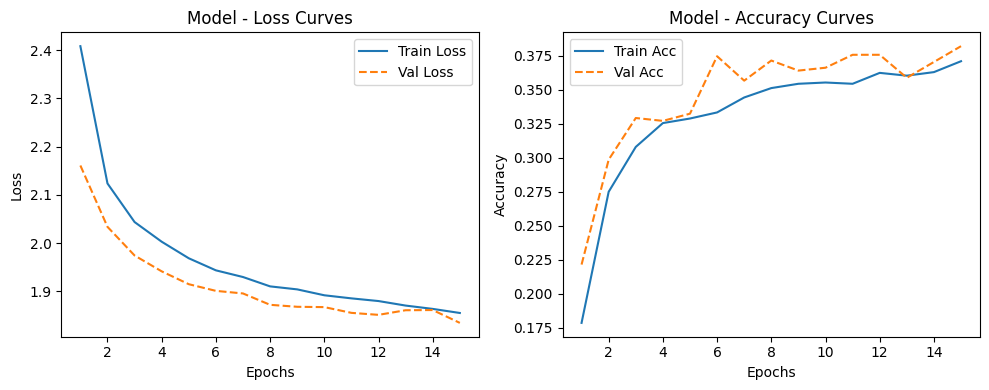

[DiffPool] Iter 2/6 | New Arch {'hidden_dim': 32, 'assign_dim': 4, 'embed_dim': 64} -> ValAcc=0.3819

[TRAINING] Model=DiffPool, ArchID=iter3
 Config: {'hidden_dim': 64, 'assign_dim': 16, 'embed_dim': 64}
Epoch 01: TrainLoss=2.3579, ValLoss=2.1198, TrainAcc=0.2076, ValAcc=0.3249
Epoch 02: TrainLoss=2.0833, ValLoss=2.0060, TrainAcc=0.2950, ValAcc=0.2996
Epoch 03: TrainLoss=2.0038, ValLoss=1.9483, TrainAcc=0.3228, ValAcc=0.3259
Epoch 04: TrainLoss=1.9441, ValLoss=1.8970, TrainAcc=0.3338, ValAcc=0.3597
Epoch 05: TrainLoss=1.9136, ValLoss=1.8829, TrainAcc=0.3446, ValAcc=0.3586
Epoch 06: TrainLoss=1.8881, ValLoss=1.8684, TrainAcc=0.3518, ValAcc=0.3797
Epoch 07: TrainLoss=1.8723, ValLoss=1.8626, TrainAcc=0.3626, ValAcc=0.3755
Epoch 08: TrainLoss=1.8523, ValLoss=1.8481, TrainAcc=0.3602, ValAcc=0.3734
Epoch 09: TrainLoss=1.8449, ValLoss=1.8352, TrainAcc=0.3622, ValAcc=0.3903
Epoch 10: TrainLoss=1.8333, ValLoss=1.8447, TrainAcc=0.3675, ValAcc=0.3713
Epoch 11: TrainLoss=1.8403, ValLoss=1.8378, T

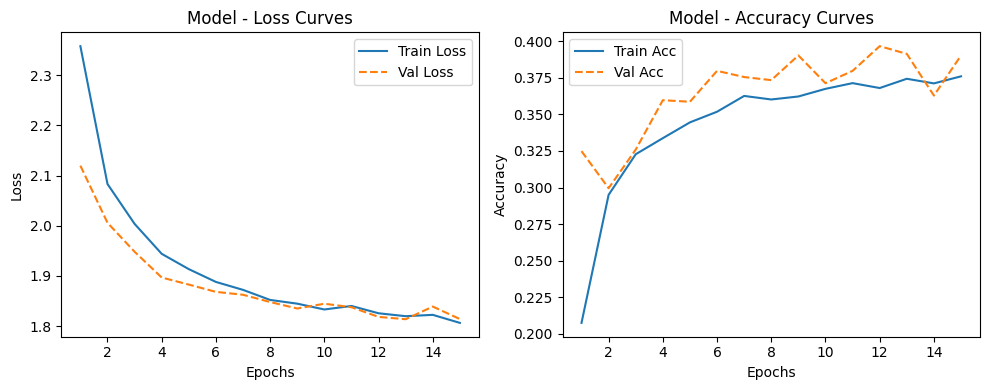

[DiffPool] Iter 3/6 | New Arch {'hidden_dim': 64, 'assign_dim': 16, 'embed_dim': 64} -> ValAcc=0.3966

[TRAINING] Model=DiffPool, ArchID=iter4
 Config: {'hidden_dim': 128, 'assign_dim': 16, 'embed_dim': 16}
Epoch 01: TrainLoss=2.4052, ValLoss=2.1700, TrainAcc=0.1499, ValAcc=0.2268
Epoch 02: TrainLoss=2.1085, ValLoss=2.0337, TrainAcc=0.2736, ValAcc=0.2890
Epoch 03: TrainLoss=2.0303, ValLoss=1.9819, TrainAcc=0.3148, ValAcc=0.3154
Epoch 04: TrainLoss=1.9743, ValLoss=1.9368, TrainAcc=0.3388, ValAcc=0.3196
Epoch 05: TrainLoss=1.9379, ValLoss=1.9128, TrainAcc=0.3431, ValAcc=0.3397
Epoch 06: TrainLoss=1.9104, ValLoss=1.8866, TrainAcc=0.3503, ValAcc=0.3713
Epoch 07: TrainLoss=1.8855, ValLoss=1.8930, TrainAcc=0.3531, ValAcc=0.3386
Epoch 08: TrainLoss=1.8731, ValLoss=1.8655, TrainAcc=0.3608, ValAcc=0.3555
Epoch 09: TrainLoss=1.8599, ValLoss=1.8670, TrainAcc=0.3632, ValAcc=0.3671
Epoch 10: TrainLoss=1.8483, ValLoss=1.8578, TrainAcc=0.3654, ValAcc=0.3692
Epoch 11: TrainLoss=1.8424, ValLoss=1.8569,

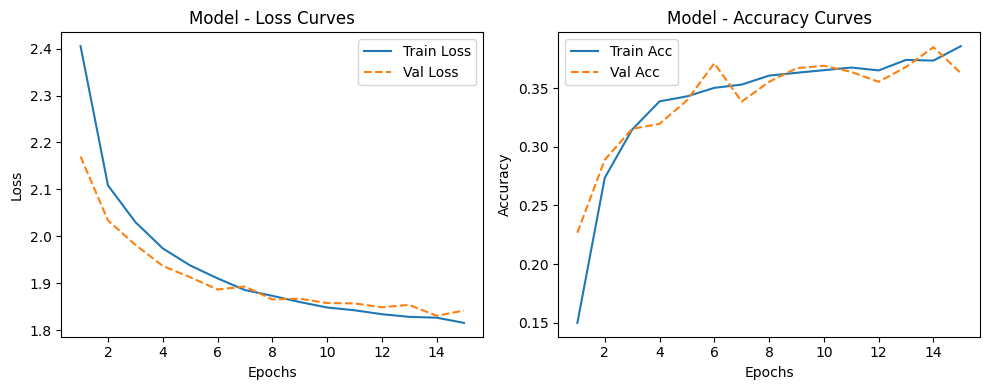

[DiffPool] Iter 4/6 | New Arch {'hidden_dim': 128, 'assign_dim': 16, 'embed_dim': 16} -> ValAcc=0.3850

[TRAINING] Model=DiffPool, ArchID=iter5
 Config: {'hidden_dim': 128, 'assign_dim': 16, 'embed_dim': 32}
Epoch 01: TrainLoss=2.3673, ValLoss=2.1291, TrainAcc=0.1763, ValAcc=0.2732
Epoch 02: TrainLoss=2.0865, ValLoss=2.0129, TrainAcc=0.3004, ValAcc=0.3175
Epoch 03: TrainLoss=1.9954, ValLoss=1.9515, TrainAcc=0.3295, ValAcc=0.3481
Epoch 04: TrainLoss=1.9420, ValLoss=1.9060, TrainAcc=0.3438, ValAcc=0.3481
Epoch 05: TrainLoss=1.9063, ValLoss=1.8877, TrainAcc=0.3552, ValAcc=0.3618
Epoch 06: TrainLoss=1.8771, ValLoss=1.8724, TrainAcc=0.3528, ValAcc=0.3565
Epoch 07: TrainLoss=1.8575, ValLoss=1.8555, TrainAcc=0.3730, ValAcc=0.3629
Epoch 08: TrainLoss=1.8503, ValLoss=1.8499, TrainAcc=0.3611, ValAcc=0.3840
Epoch 09: TrainLoss=1.8364, ValLoss=1.8553, TrainAcc=0.3729, ValAcc=0.3787
Epoch 10: TrainLoss=1.8339, ValLoss=1.8409, TrainAcc=0.3676, ValAcc=0.3745
Epoch 11: TrainLoss=1.8262, ValLoss=1.8335

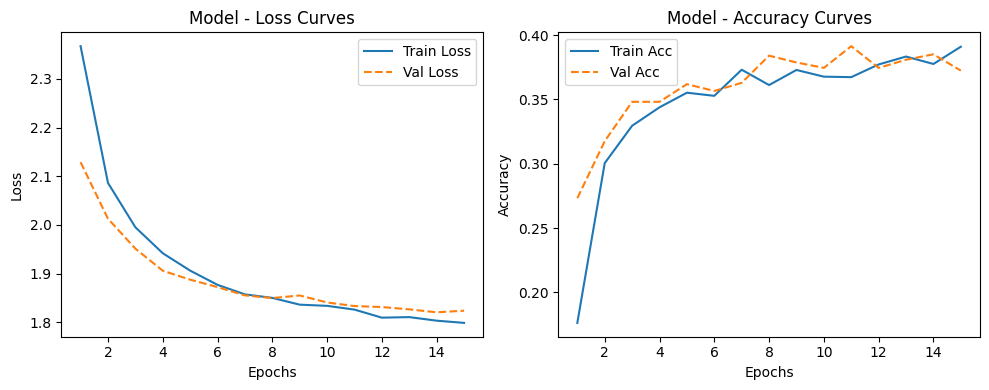

[DiffPool] Iter 5/6 | New Arch {'hidden_dim': 128, 'assign_dim': 16, 'embed_dim': 32} -> ValAcc=0.3914

[TRAINING] Model=DiffPool, ArchID=iter6
 Config: {'hidden_dim': 128, 'assign_dim': 16, 'embed_dim': 64}
Epoch 01: TrainLoss=2.3013, ValLoss=2.0786, TrainAcc=0.2277, ValAcc=0.2838
Epoch 02: TrainLoss=2.0341, ValLoss=1.9694, TrainAcc=0.3124, ValAcc=0.3133
Epoch 03: TrainLoss=1.9493, ValLoss=1.9119, TrainAcc=0.3449, ValAcc=0.3428
Epoch 04: TrainLoss=1.9019, ValLoss=1.8841, TrainAcc=0.3505, ValAcc=0.3544
Epoch 05: TrainLoss=1.8657, ValLoss=1.8698, TrainAcc=0.3533, ValAcc=0.3681
Epoch 06: TrainLoss=1.8534, ValLoss=1.8474, TrainAcc=0.3654, ValAcc=0.3766
Epoch 07: TrainLoss=1.8367, ValLoss=1.8611, TrainAcc=0.3708, ValAcc=0.3481
Epoch 08: TrainLoss=1.8251, ValLoss=1.8440, TrainAcc=0.3764, ValAcc=0.3914
Epoch 09: TrainLoss=1.8170, ValLoss=1.8402, TrainAcc=0.3719, ValAcc=0.3787
Epoch 10: TrainLoss=1.8101, ValLoss=1.8222, TrainAcc=0.3835, ValAcc=0.3755
Epoch 11: TrainLoss=1.8002, ValLoss=1.8177

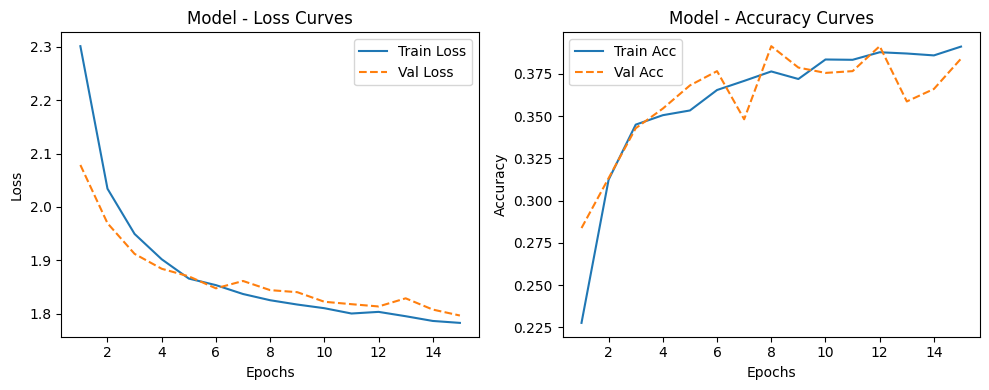

[DiffPool] Iter 6/6 | New Arch {'hidden_dim': 128, 'assign_dim': 16, 'embed_dim': 64} -> ValAcc=0.3914

=== Best DiffPool Architecture ===
{'hidden_dim': np.float32(64.0), 'assign_dim': np.float32(4.0), 'embed_dim': np.float32(64.0)} Validation Accuracy: 0.3966
Best GIN Architecture: {'hidden_dim': np.float32(128.0), 'num_layers': np.float32(5.0), 'dropout': np.float32(0.006632481)}
Best GAT Architecture: {'hidden_dim': np.float32(64.0), 'num_layers': np.float32(4.0), 'dropout': np.float32(0.020129), 'num_heads': np.float32(8.0)}
Best DiffPool Architecture: {'hidden_dim': np.float32(64.0), 'assign_dim': np.float32(4.0), 'embed_dim': np.float32(64.0)}


In [46]:
# Arch search spaces
arch_space_gin = {
    "hidden_dim": [32, 64, 128],
    "num_layers": [2, 3, 4, 5],
    "dropout": [0.0, 0.25, 0.5]
}
arch_space_gat = {
    "hidden_dim": [32, 64, 128],
    "num_layers": [2, 3, 4, 5],
    "dropout": [0.0, 0.25, 0.5],
    "num_heads": [2, 4, 8]
}
arch_space_diff = {
    "hidden_dim": [32, 64, 128],
    "assign_dim": [4, 8, 16],
    "embed_dim": [16, 32, 64]
}

BANANAS_CONFIG = {
    'num_init': 3,
    'num_iter': 6,
    'short_epochs': 15,
    'candidates_per_iter': 50,
    'surrogate_epochs': 80,
    'surrogate_n_models': 7,
    'surrogate_lr': 1e-3,
    'batch_size': 16,
    'short_lr': 1e-3,
    'short_wd': 5e-4,
    'ei_xi': 0.01
}
# BANANAS architecture search for each model (validation accuracy objective)
best_arch_gin, _  = bananas_search(model_name='GIN', model_class=GINNet, arch_space=arch_space_gin, train_dataset=train_dataset, config=BANANAS_CONFIG)
best_arch_gat, _  = bananas_search(model_name='GAT', model_class=GATNet, arch_space=arch_space_gat, train_dataset=train_dataset, config=BANANAS_CONFIG)
best_arch_diff, _ = bananas_search(model_name='DiffPool', model_class=DiffPoolNet, arch_space=arch_space_diff, train_dataset=train_dataset, config=BANANAS_CONFIG)

print("Best GIN Architecture:", best_arch_gin)
print("Best GAT Architecture:", best_arch_gat)
print("Best DiffPool Architecture:", best_arch_diff)

**MANGO Hyperparameter Tuning**  
The objective uses short training on the internal train/val split (85/15).


In [100]:
# === Universal type cleaner ===
def clean_arch_config(arch_config):
    """Convert all numeric values to proper Python types for model building."""
    cleaned = {}
    for k, v in arch_config.items():
        if isinstance(v, (list, np.ndarray)):
            # just take first if accidentally a list or np array
            v = v[0] if len(v) > 0 else v
        if isinstance(v, (np.integer, int)):
            cleaned[k] = int(v)
        elif isinstance(v, (np.floating, float)):
            # if e.g. 3.0 → 3
            cleaned[k] = int(v) if float(v).is_integer() else float(v)
        else:
            cleaned[k] = v
    return cleaned

# === Mango objective factory ===
def make_mango_objective(model_cls, arch_config, train_dataset,
                         num_classes, device,
                         short_epochs=10):
    """
    Objective function for Mango tuning.
    Returns 1 - validation_accuracy to be minimized.
    """
    @scheduler.serial
    def objective(**params):
        # params: a dict provided by Mango for this trial
        # get search params
        lr = float(params.get('lr', 1e-3))
        wd = float(params.get('weight_decay', 5e-4))
        bs = int(params.get('batch_size', 64))

        print(f"\nParams: lr={lr}, weight_decay={wd}, batch_size={bs}")

        # DataLoaders local to this call
        train_loader = GraphDataLoader(train_subset, batch_size=bs, shuffle=True)
        val_loader = GraphDataLoader(val_subset, batch_size=bs, shuffle=False)

        # clean config to safe numeric types
        arch_cfg_clean = clean_arch_config(arch_config)

        # build model
        in_feats = train_dataset[0][0].ndata['feat'].shape[1]
        model = _build_model_from_cls(model_cls,
                                      arch_cfg_clean,
                                      in_feats,
                                      num_classes,
                                      device)

        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        loss_fn = nn.CrossEntropyLoss()

        # quick training
        model, history = train_model(
                          model, train_loader, val_loader, loss_fn, optimizer,
                          device, num_epochs=short_epochs
                          )

        best_val_acc = max(history.get('val_acc', [0.0]))

        # Mango minimizes by default → we return 1 - accuracy
        return 1.0 - float(best_val_acc) # minimize (lower is better)

    return objective

def run_mango_tuning(model_cls, best_arch, train_dataset, mango_space=None,
                     num_iter=10, short_epochs=10, plot_convergence=True):
    """
    Run Mango tuner and return best hyperparameters dict.
    - model_cls: model class (GINNet, GATNet, DiffPoolNet)
    - best_arch: architecture dict found by BANANAS (used to build model)
    - train_dataset: the Dataset object (train only)
    - mango_space: dict param -> list (categorical)
    """
    print(f"\n===== MANGO Hyperparameter Tuning for {model_cls.__name__} =====")

    arch_cfg_clean = clean_arch_config(best_arch)
    print("Best Architecture:", arch_cfg_clean)

    objective = make_mango_objective(
        model_cls=model_cls,
        arch_config=arch_cfg_clean,
        train_dataset=train_dataset,
        num_classes=num_classes,
        device=device,
        short_epochs=short_epochs
    )

    # prepare param space
    param_space = mango_space

    # Mango Config
    print(f"\n[MANGO] Initial random trials = {2} / Total trials = {num_iter}")

    # Configure the Mango tuner
    conf = {
        'num_iteration': num_iter,
        'initial_random': 2,
        'domain_size': 2000,
        'batch_size': 1
    }

    # Initialize and run Tuner
    tuner = Tuner(param_space, objective, conf)
    results = tuner.minimize()
    print(f"\n[MANGO] Best hyperparameters for {model_cls.__name__}: {results['best_params']}")

    # Final best params
    best_params = results.get('best_params')
    best_obj = results.get('best_objective')
    best_acc = 1 - best_obj

    print(f"\n[MANGO] {model_cls.__name__}: ")
    print(f"Best params: {best_params}")
    print(f"Best val accuracy: {best_acc:.4f}")

    # Optional convergence plot
    obj_vals = results.get('objective_values')
    if plot_convergence and obj_vals is not None:
        accs = [1 - float(x) for x in obj_vals]
        plt.figure(figsize=(6,4))
        plt.plot(accs, marker='o')
        plt.xlabel("Iteration")
        plt.ylabel("Validation Accuracy")
        plt.title(f"MANGO Convergence - {model_cls.__name__}")
        plt.grid(True)
        plt.show()

    return best_params, results

### Run Mango tuning for hyperparameter tuning


===== MANGO Hyperparameter Tuning for GINNet =====
Best Architecture: {'hidden_dim': 128, 'num_layers': 5, 'dropout': 0.0066324807703495026}

[MANGO] Initial random trials = 2 / Total trials = 10

Params: lr=0.001, weight_decay=0.001, batch_size=16
Epoch 01: TrainLoss=2.0444, ValLoss=1.8908, TrainAcc=0.3057, ValAcc=0.3608
Epoch 02: TrainLoss=1.9130, ValLoss=1.8679, TrainAcc=0.3475, ValAcc=0.3734
Epoch 03: TrainLoss=1.8780, ValLoss=1.8020, TrainAcc=0.3643, ValAcc=0.3977
Epoch 04: TrainLoss=1.8375, ValLoss=1.8872, TrainAcc=0.3816, ValAcc=0.3692
Epoch 05: TrainLoss=1.8217, ValLoss=1.8359, TrainAcc=0.3933, ValAcc=0.3713
Epoch 06: TrainLoss=1.8110, ValLoss=1.7969, TrainAcc=0.3926, ValAcc=0.3861
Epoch 07: TrainLoss=1.7915, ValLoss=1.7629, TrainAcc=0.3915, ValAcc=0.4019
Epoch 08: TrainLoss=1.7926, ValLoss=1.8096, TrainAcc=0.3898, ValAcc=0.4051
Epoch 09: TrainLoss=1.7805, ValLoss=1.7539, TrainAcc=0.3991, ValAcc=0.4177
Epoch 10: TrainLoss=1.7745, ValLoss=1.7751, TrainAcc=0.3978, ValAcc=0.3966


  0%|          | 0/10 [00:00<?, ?it/s]


Params: lr=0.0005, weight_decay=1e-05, batch_size=64
Epoch 01: TrainLoss=2.0614, ValLoss=1.8554, TrainAcc=0.3317, ValAcc=0.3745
Epoch 02: TrainLoss=1.7925, ValLoss=1.8377, TrainAcc=0.3984, ValAcc=0.3797
Epoch 03: TrainLoss=1.7437, ValLoss=1.7738, TrainAcc=0.4097, ValAcc=0.4156
Epoch 04: TrainLoss=1.7253, ValLoss=1.8027, TrainAcc=0.4101, ValAcc=0.3871
Epoch 05: TrainLoss=1.7063, ValLoss=1.7392, TrainAcc=0.4201, ValAcc=0.4167
Epoch 06: TrainLoss=1.6870, ValLoss=1.7364, TrainAcc=0.4224, ValAcc=0.4283
Epoch 07: TrainLoss=1.6653, ValLoss=1.7263, TrainAcc=0.4280, ValAcc=0.4114
Epoch 08: TrainLoss=1.6532, ValLoss=1.7145, TrainAcc=0.4283, ValAcc=0.4177
Epoch 09: TrainLoss=1.6471, ValLoss=1.7188, TrainAcc=0.4335, ValAcc=0.4177
Epoch 10: TrainLoss=1.6354, ValLoss=1.7516, TrainAcc=0.4408, ValAcc=0.4241

Params: lr=0.0005, weight_decay=0.0005, batch_size=32
Epoch 01: TrainLoss=1.9903, ValLoss=1.8346, TrainAcc=0.3360, ValAcc=0.4030
Epoch 02: TrainLoss=1.8187, ValLoss=1.8200, TrainAcc=0.3777, ValAc

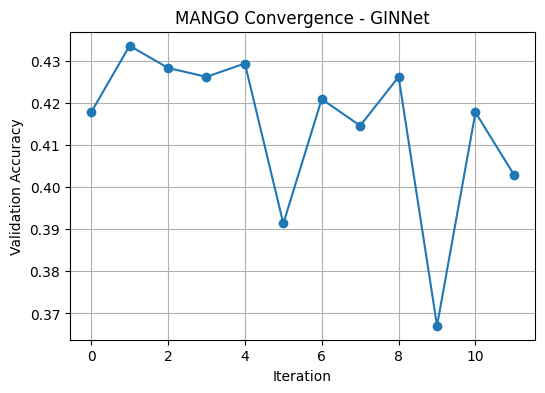


===== MANGO Hyperparameter Tuning for GATNet =====
Best Architecture: {'hidden_dim': 64, 'num_layers': 4, 'dropout': 0.020129000768065453, 'num_heads': 8}

[MANGO] Initial random trials = 2 / Total trials = 10

Params: lr=0.005, weight_decay=0.0005, batch_size=64
Epoch 01: TrainLoss=2.0576, ValLoss=1.9303, TrainAcc=0.2941, ValAcc=0.3365
Epoch 02: TrainLoss=1.8729, ValLoss=1.9065, TrainAcc=0.3520, ValAcc=0.3365
Epoch 03: TrainLoss=1.8275, ValLoss=1.8542, TrainAcc=0.3665, ValAcc=0.3428
Epoch 04: TrainLoss=1.8135, ValLoss=1.8408, TrainAcc=0.3697, ValAcc=0.3903
Epoch 05: TrainLoss=1.7944, ValLoss=1.8670, TrainAcc=0.3794, ValAcc=0.3724
Epoch 06: TrainLoss=1.7909, ValLoss=1.8238, TrainAcc=0.3818, ValAcc=0.3734
Epoch 07: TrainLoss=1.7735, ValLoss=1.8050, TrainAcc=0.3810, ValAcc=0.3819
Epoch 08: TrainLoss=1.7465, ValLoss=1.7886, TrainAcc=0.3978, ValAcc=0.3692
Epoch 09: TrainLoss=1.7440, ValLoss=1.7767, TrainAcc=0.3999, ValAcc=0.3914
Epoch 10: TrainLoss=1.7367, ValLoss=1.7965, TrainAcc=0.4030,

  0%|          | 0/10 [00:00<?, ?it/s]


Params: lr=0.001, weight_decay=0.001, batch_size=16
Epoch 01: TrainLoss=2.0819, ValLoss=1.9439, TrainAcc=0.2978, ValAcc=0.3323
Epoch 02: TrainLoss=1.8849, ValLoss=1.8766, TrainAcc=0.3533, ValAcc=0.3460
Epoch 03: TrainLoss=1.8328, ValLoss=1.8622, TrainAcc=0.3682, ValAcc=0.3703
Epoch 04: TrainLoss=1.8146, ValLoss=1.8302, TrainAcc=0.3671, ValAcc=0.3534
Epoch 05: TrainLoss=1.8021, ValLoss=1.8225, TrainAcc=0.3805, ValAcc=0.3660
Epoch 06: TrainLoss=1.7897, ValLoss=1.8041, TrainAcc=0.3799, ValAcc=0.3629
Epoch 07: TrainLoss=1.7776, ValLoss=1.8129, TrainAcc=0.3926, ValAcc=0.3755
Epoch 08: TrainLoss=1.7669, ValLoss=1.8078, TrainAcc=0.3827, ValAcc=0.3544
Epoch 09: TrainLoss=1.7639, ValLoss=1.7939, TrainAcc=0.3937, ValAcc=0.3808
Epoch 10: TrainLoss=1.7592, ValLoss=1.7864, TrainAcc=0.3874, ValAcc=0.3850

Params: lr=0.005, weight_decay=0.0005, batch_size=16
Epoch 01: TrainLoss=2.0163, ValLoss=1.9460, TrainAcc=0.3008, ValAcc=0.3428
Epoch 02: TrainLoss=1.8910, ValLoss=1.9878, TrainAcc=0.3500, ValAcc=

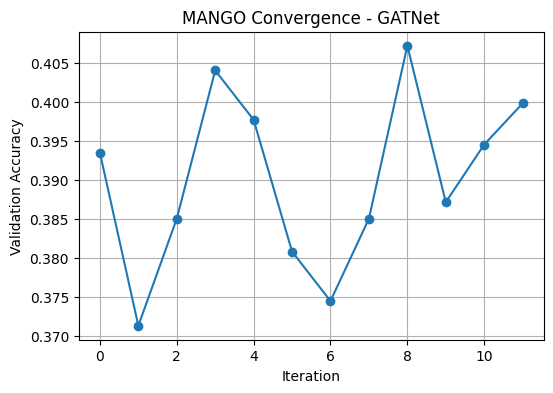


===== MANGO Hyperparameter Tuning for DiffPoolNet =====
Best Architecture: {'hidden_dim': 64, 'assign_dim': 4, 'embed_dim': 64}

[MANGO] Initial random trials = 2 / Total trials = 10

Params: lr=0.001, weight_decay=0.0005, batch_size=64
Epoch 01: TrainLoss=2.5124, ValLoss=2.4034, TrainAcc=0.1433, ValAcc=0.1973
Epoch 02: TrainLoss=2.2803, ValLoss=2.1539, TrainAcc=0.2083, ValAcc=0.2205
Epoch 03: TrainLoss=2.1366, ValLoss=2.0614, TrainAcc=0.2651, ValAcc=0.2922
Epoch 04: TrainLoss=2.0564, ValLoss=2.0075, TrainAcc=0.2962, ValAcc=0.3186
Epoch 05: TrainLoss=2.0188, ValLoss=1.9832, TrainAcc=0.3274, ValAcc=0.3228
Epoch 06: TrainLoss=1.9879, ValLoss=1.9598, TrainAcc=0.3267, ValAcc=0.3407
Epoch 07: TrainLoss=1.9573, ValLoss=1.9282, TrainAcc=0.3459, ValAcc=0.3228
Epoch 08: TrainLoss=1.9316, ValLoss=1.9079, TrainAcc=0.3481, ValAcc=0.3407
Epoch 09: TrainLoss=1.9081, ValLoss=1.8925, TrainAcc=0.3578, ValAcc=0.3492
Epoch 10: TrainLoss=1.8963, ValLoss=1.8826, TrainAcc=0.3492, ValAcc=0.3544

Params: lr=

  0%|          | 0/10 [00:00<?, ?it/s]


Params: lr=0.001, weight_decay=0.0005, batch_size=16
Epoch 01: TrainLoss=2.3483, ValLoss=2.0956, TrainAcc=0.1940, ValAcc=0.2943
Epoch 02: TrainLoss=2.0736, ValLoss=1.9961, TrainAcc=0.2969, ValAcc=0.3228
Epoch 03: TrainLoss=2.0006, ValLoss=1.9393, TrainAcc=0.3194, ValAcc=0.3354
Epoch 04: TrainLoss=1.9456, ValLoss=1.9000, TrainAcc=0.3414, ValAcc=0.3470
Epoch 05: TrainLoss=1.9098, ValLoss=1.8799, TrainAcc=0.3490, ValAcc=0.3639
Epoch 06: TrainLoss=1.8824, ValLoss=1.8721, TrainAcc=0.3503, ValAcc=0.3629
Epoch 07: TrainLoss=1.8699, ValLoss=1.8447, TrainAcc=0.3550, ValAcc=0.3703
Epoch 08: TrainLoss=1.8544, ValLoss=1.8469, TrainAcc=0.3617, ValAcc=0.3903
Epoch 09: TrainLoss=1.8461, ValLoss=1.8401, TrainAcc=0.3682, ValAcc=0.3766
Epoch 10: TrainLoss=1.8401, ValLoss=1.8377, TrainAcc=0.3613, ValAcc=0.3692

Params: lr=0.0005, weight_decay=0.0005, batch_size=16
Epoch 01: TrainLoss=2.4975, ValLoss=2.3524, TrainAcc=0.1385, ValAcc=0.1920
Epoch 02: TrainLoss=2.2384, ValLoss=2.1190, TrainAcc=0.2185, ValAc

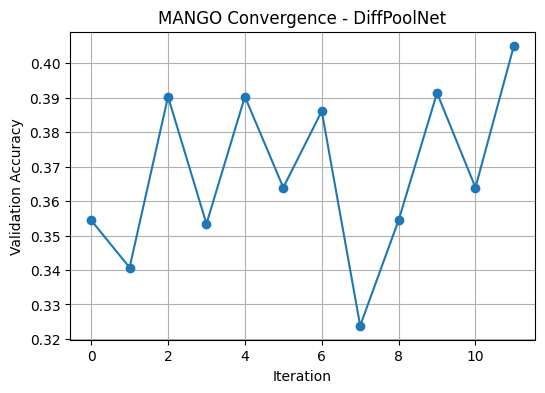

In [101]:
# Search space
MANGO_SPACE = {
    'lr': [0.0005, 0.001, 0.005],
    'weight_decay': [1e-5, 5e-4, 1e-3],
    'batch_size': [16, 32, 64]
}
# GIN model
best_hparams_gin = run_mango_tuning(GINNet, best_arch_gin, train_dataset, MANGO_SPACE)
#print("Best MANGO hyperparameters (GIN):", best_hparams_gin)
# GAT model
best_hparams_gat = run_mango_tuning(GATNet, best_arch_gat, train_dataset, MANGO_SPACE)
#print("Best MANGO hyperparameters (GAT):", best_hparams_gat)
# DiffPool model
best_hparams_diff = run_mango_tuning(DiffPoolNet, best_arch_diff, train_dataset, MANGO_SPACE)
#print("Best MANGO hyperparameters (DiffPool):", best_hparams_diff)

**Final Training & Reporting**  
Train the chosen architecture with tuned hyperparameters on the **full training set** (no 85/15 split here) and evaluate on the **exact provided test set**. Then produce:
- AUC-ROC (macro)
- AUC-PR (macro)
- Simple misclassification percentage (misclassified / total * 100)
- Plots for ROC and PR per class


In [129]:
def final_train_and_report(model_cls, arch_config, best_hparams,
                           device=device, epochs=50):
    """
    Final full training + validation + test evaluation with the best architecture and hyperparameters.
    Compute final metrics (Accuracy, AUC-ROC, AUC-PR, Misclassification %).
    Uses:
      - train_model()    → returns model + training history
      - evaluate_metrics_collect() → returns dict of metrics (acc/loss/cm)
    Inputs:
      model_cls:      class of GNN model (GINNet, GATNet, DiffPoolNet)
      arch_config:    dict of architecture config (from BANANAS)
      best_hparams:   dict of best hyperparameters (from Mango)
      device:         'cuda' or 'cpu'
      epochs:         number of training epochs
    Returns:
      model: trained model
      history: dict containing curves
      test_metrics: dict with accuracy, loss, confusion matrix
    """

    lr = best_hparams['lr']
    wd = best_hparams['weight_decay']
    bs = best_hparams['batch_size']

    # Prepare full data loaders
    train_loader = GraphDataLoader(train_subset, batch_size=bs, shuffle=True)
    val_loader   = GraphDataLoader(val_subset, batch_size=bs, shuffle=False)
    test_loader  = GraphDataLoader(test_dataset, batch_size=bs, shuffle=False)

    # Prepare model
    in_feats = train_graphs[0].ndata['feat'].shape[1]
    arch_cfg_clean = clean_arch_config(arch_config)

    model = _build_model_from_cls(model_cls, arch_cfg_clean, in_feats, num_classes, device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    loss_fn = nn.CrossEntropyLoss()

    print(f"\n[Final Training] {model_cls.__name__}")
    print("Best Architecture:", arch_cfg_clean)
    print("Best hyperparameters:", best_hparams)

    # --- full training ---
    # Train with best architecture and hyperparameters
    model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device,
        num_epochs=epochs
    )

    print("\n>>> Final training completed.")
    print(f"\n========Results for {model_cls.__name__}========")
    print(f"Best Validation Accuracy: {max(history['val_acc']):.4f}")

    # --- evaluation on test set ---
    print("\nEvaluating on TEST set ...")
    test_metrics, probs, labels = evaluate_metrics_collect(model, test_loader, device)

    print("\nFinal Test Metrics:")
    # Display test_metrics as a DataFrame for better readability
    metrics_df = pd.DataFrame([test_metrics])
    display(metrics_df)

    return model, test_metrics, probs, labels

In [133]:
# Run final training
gin_best_hparams, _ = best_hparams_gin # Unpack the tuple
gin_model, gin_metrics, gin_probs, gin_labels = final_train_and_report(GINNet, best_arch_gin, gin_best_hparams)

gat_best_hparams, _ = best_hparams_gat # Unpack the tuple
gat_model, gat_metrics, gat_probs, gat_labels = final_train_and_report(GATNet, best_arch_gat, gat_best_hparams)

diff_best_hparams, _ = best_hparams_diff # Unpack the tuple
diff_model, diff_metrics, diff_probs, diff_labels = final_train_and_report(DiffPoolNet, best_arch_diff, diff_best_hparams)


[Final Training] GINNet
Best Architecture: {'hidden_dim': 128, 'num_layers': 5, 'dropout': 0.0066324807703495026}
Best hyperparameters: {'weight_decay': 0.001, 'lr': 0.0005, 'batch_size': 32}
Epoch 01: TrainLoss=2.0166, ValLoss=1.8219, TrainAcc=0.3319, ValAcc=0.3797
Epoch 02: TrainLoss=1.8156, ValLoss=1.8736, TrainAcc=0.3846, ValAcc=0.3629
Epoch 03: TrainLoss=1.7670, ValLoss=1.7917, TrainAcc=0.3976, ValAcc=0.3903
Epoch 04: TrainLoss=1.7376, ValLoss=1.7531, TrainAcc=0.4047, ValAcc=0.3924
Epoch 05: TrainLoss=1.7304, ValLoss=1.7577, TrainAcc=0.4136, ValAcc=0.3998
Epoch 06: TrainLoss=1.7112, ValLoss=1.7980, TrainAcc=0.4144, ValAcc=0.3935
Epoch 07: TrainLoss=1.7086, ValLoss=1.7416, TrainAcc=0.4216, ValAcc=0.4082
Epoch 08: TrainLoss=1.6846, ValLoss=1.7486, TrainAcc=0.4211, ValAcc=0.4156
Epoch 09: TrainLoss=1.6849, ValLoss=1.7315, TrainAcc=0.4259, ValAcc=0.4114
Epoch 10: TrainLoss=1.6806, ValLoss=1.7483, TrainAcc=0.4241, ValAcc=0.4040
Epoch 11: TrainLoss=1.6703, ValLoss=1.7464, TrainAcc=0.43

,loss,accuracy,auc_roc,auc_pr,misclassification_pct
0,1.708844,0.398462,0.858929,0.414316,60.153846



[Final Training] GATNet
Best Architecture: {'hidden_dim': 64, 'num_layers': 4, 'dropout': 0.020129000768065453, 'num_heads': 8}
Best hyperparameters: {'batch_size': 16, 'lr': 0.005, 'weight_decay': 1e-05}
Epoch 01: TrainLoss=2.0105, ValLoss=1.9243, TrainAcc=0.3120, ValAcc=0.3481
Epoch 02: TrainLoss=1.8795, ValLoss=1.9113, TrainAcc=0.3518, ValAcc=0.3671
Epoch 03: TrainLoss=1.8548, ValLoss=1.8160, TrainAcc=0.3630, ValAcc=0.3745
Epoch 04: TrainLoss=1.7991, ValLoss=1.8617, TrainAcc=0.3835, ValAcc=0.3629
Epoch 05: TrainLoss=1.7914, ValLoss=1.8163, TrainAcc=0.3825, ValAcc=0.3882
Epoch 06: TrainLoss=1.7796, ValLoss=1.9002, TrainAcc=0.3933, ValAcc=0.3977
Epoch 07: TrainLoss=1.7704, ValLoss=1.8160, TrainAcc=0.3887, ValAcc=0.4103
Epoch 08: TrainLoss=1.7627, ValLoss=1.7881, TrainAcc=0.3959, ValAcc=0.4008
Epoch 09: TrainLoss=1.7582, ValLoss=1.7784, TrainAcc=0.3956, ValAcc=0.4198
Epoch 10: TrainLoss=1.7374, ValLoss=1.7853, TrainAcc=0.4002, ValAcc=0.3755
Epoch 11: TrainLoss=1.7369, ValLoss=1.7939, 

,loss,accuracy,auc_roc,auc_pr,misclassification_pct
0,1.783476,0.396538,0.850681,0.403861,60.346154



[Final Training] DiffPoolNet
Best Architecture: {'hidden_dim': 64, 'assign_dim': 4, 'embed_dim': 64}
Best hyperparameters: {'batch_size': 32, 'lr': 0.005, 'weight_decay': 1e-05}
Epoch 01: TrainLoss=2.1825, ValLoss=1.9569, TrainAcc=0.2558, ValAcc=0.3291
Epoch 02: TrainLoss=1.9261, ValLoss=1.8682, TrainAcc=0.3451, ValAcc=0.3618
Epoch 03: TrainLoss=1.8706, ValLoss=1.8591, TrainAcc=0.3513, ValAcc=0.3608
Epoch 04: TrainLoss=1.8427, ValLoss=1.8134, TrainAcc=0.3762, ValAcc=0.3892
Epoch 05: TrainLoss=1.8187, ValLoss=1.8362, TrainAcc=0.3686, ValAcc=0.3618
Epoch 06: TrainLoss=1.8042, ValLoss=1.8398, TrainAcc=0.3777, ValAcc=0.3597
Epoch 07: TrainLoss=1.8008, ValLoss=1.7957, TrainAcc=0.3822, ValAcc=0.3734
Epoch 08: TrainLoss=1.7949, ValLoss=1.8053, TrainAcc=0.3801, ValAcc=0.3692
Epoch 09: TrainLoss=1.7751, ValLoss=1.8024, TrainAcc=0.3900, ValAcc=0.3840
Epoch 10: TrainLoss=1.7751, ValLoss=1.7808, TrainAcc=0.3887, ValAcc=0.3850
Epoch 11: TrainLoss=1.7613, ValLoss=1.7930, TrainAcc=0.3935, ValAcc=0.3

,loss,accuracy,auc_roc,auc_pr,misclassification_pct
0,1.745649,0.395385,0.852723,0.399366,60.461538


To compare the performance of the GIN, GAT, and DiffPool models, I'll create a pandas DataFrame that displays their key metrics: AUC-ROC, AUC-PR, Misclassification Percentage, and Accuracy.

In [135]:
import pandas as pd

# 1. Create a dictionary for each model
model_performance = [
    {
        'Model': 'GIN',
        'AUC-ROC': gin_metrics['auc_roc'],
        'AUC-PR': gin_metrics['auc_pr'],
        'Misclassification Percentage': gin_metrics['misclassification_pct'],
        'Accuracy': gin_metrics['accuracy']
    },
    {
        'Model': 'GAT',
        'AUC-ROC': gat_metrics['auc_roc'],
        'AUC-PR': gat_metrics['auc_pr'],
        'Misclassification Percentage': gat_metrics['misclassification_pct'],
        'Accuracy': gat_metrics['accuracy']
    },
    {
        'Model': 'DiffPool',
        'AUC-ROC': diff_metrics['auc_roc'],
        'AUC-PR': diff_metrics['auc_pr'],
        'Misclassification Percentage': diff_metrics['misclassification_pct'],
        'Accuracy': diff_metrics['accuracy']
    }
]

# 2. Create a pandas DataFrame from this list of dictionaries.
df_performance = pd.DataFrame(model_performance)

# 3. Set the 'Model' column as the index of the DataFrame.
df_performance.set_index('Model', inplace=True)

# 4. Display the DataFrame
print("\n--- Model Performance Comparison ---")
display(df_performance)


--- Model Performance Comparison ---


,AUC-ROC,AUC-PR,Misclassification Percentage,Accuracy
Model,,,,
GIN,0.858929,0.414316,60.153846,0.398462
GAT,0.850681,0.403861,60.346154,0.396538
DiffPool,0.852723,0.399366,60.461538,0.395385


**Final Visualization**  
Plot AUC-ROC and AUC-PR (per model).

In [153]:
def plot_roc_pr_multiclass(probs, labels, model_name="Model"):
    """Plot per-class ROC and Precision-Recall curves side-by-side."""
    n_classes = probs.shape[1]
    y_true = label_binarize(labels, classes=np.arange(n_classes))

    fig, axes = plt.subplots(1, 2, figsize=(14, 5)) # Create a figure with 2 subplots side-by-side

    # ROC curves on the first subplot
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], probs[:, i])
        axes[0].plot(fpr, tpr, label=f"Class {i}")
    axes[0].plot([0, 1], [0, 1], 'k--')
    axes[0].set_title(f"AUC-ROC Curves — {model_name}")
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[0].legend(fontsize=8)
    axes[0].grid(True)

    # PR curves on the second subplot
    for i in range(n_classes):
        prec, rec, _ = precision_recall_curve(y_true[:, i], probs[:, i])
        axes[1].plot(rec, prec, label=f"Class {i}")
    axes[1].set_title(f"AUC-PR Curves — {model_name}")
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")
    axes[1].legend(fontsize=8)
    axes[1].grid(True)

    plt.tight_layout() # Adjust layout to prevent overlapping elements
    plt.show()

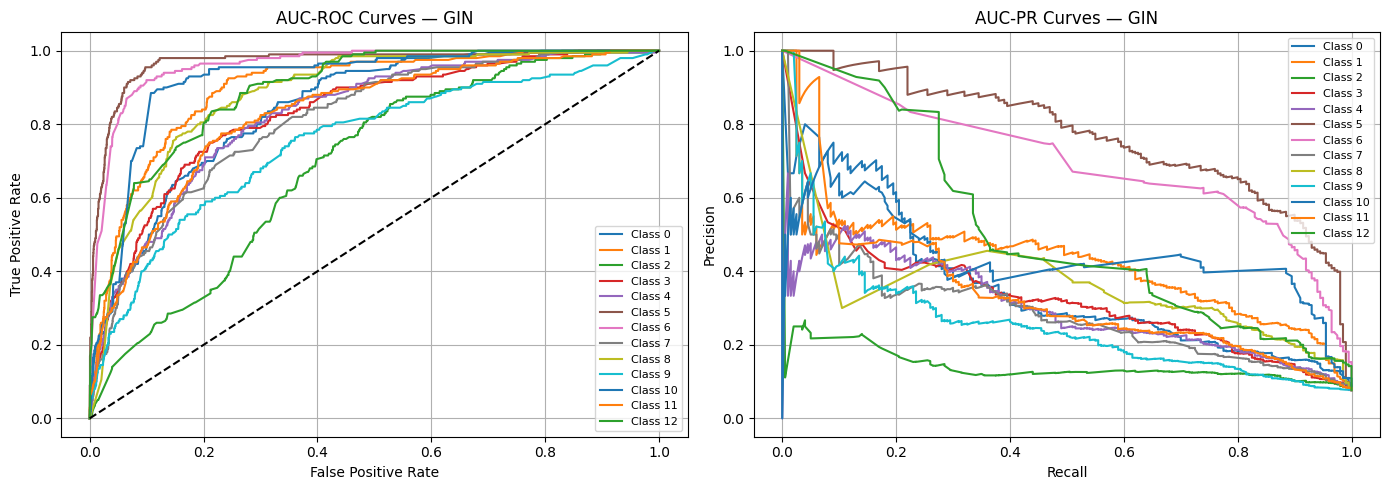

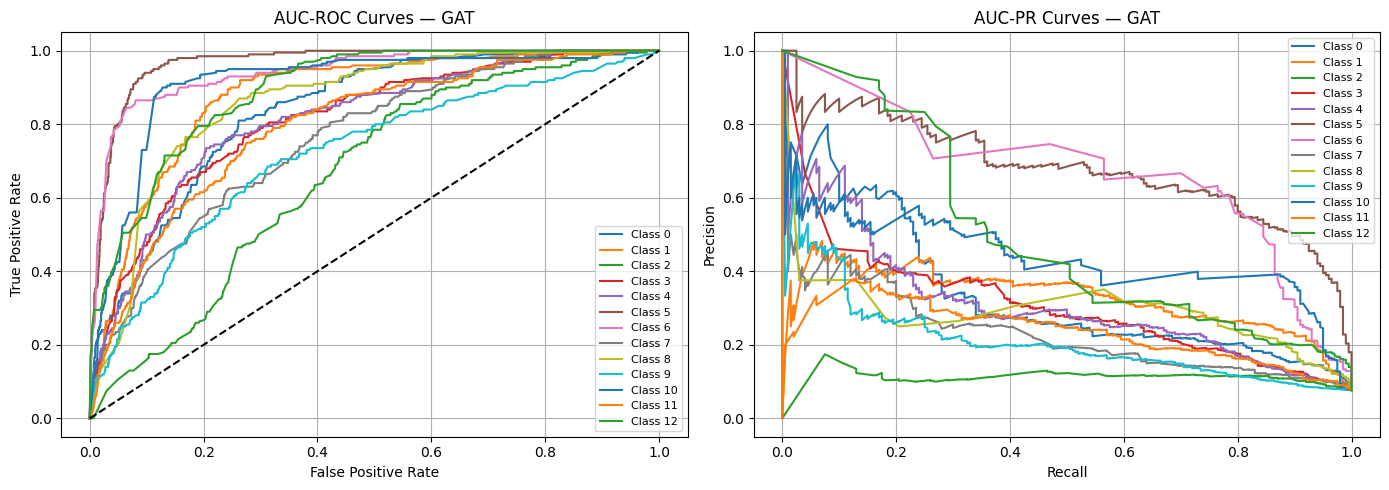

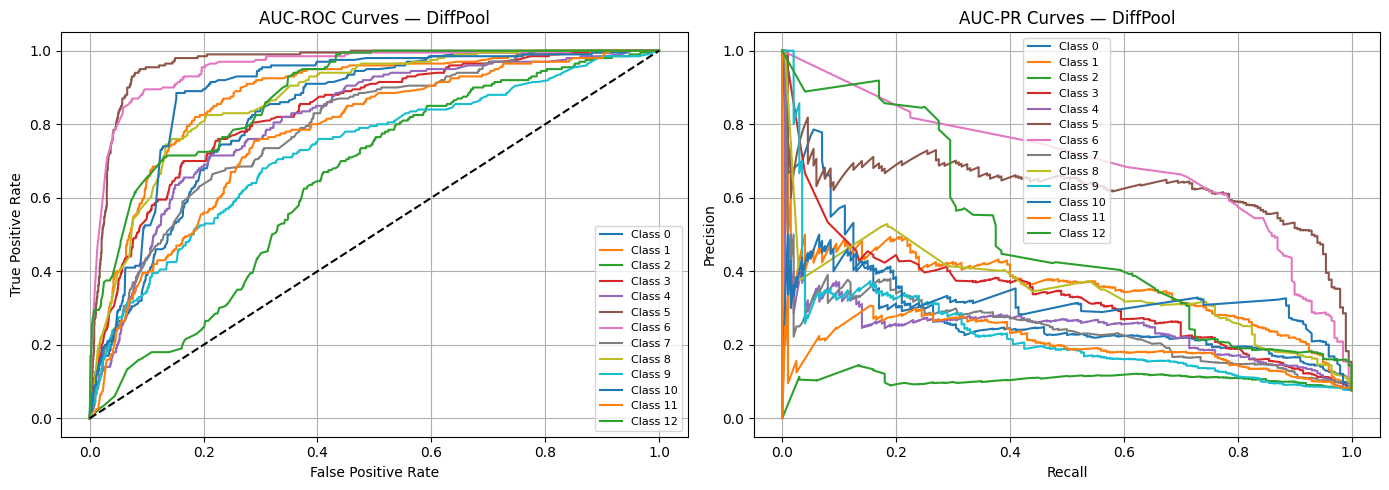

In [154]:
# plotting AUC-ROC and AUC-PR curves for each model
plot_roc_pr_multiclass(gin_probs, gin_labels, "GIN")
plot_roc_pr_multiclass(gat_probs, gat_labels, "GAT")
plot_roc_pr_multiclass(diff_probs, diff_labels, "DiffPool")

**Model Comparison: ROC and PR**

This section evaluates GIN, GAT, and DiffPool using the same test dataset to ensure a fair comparison.

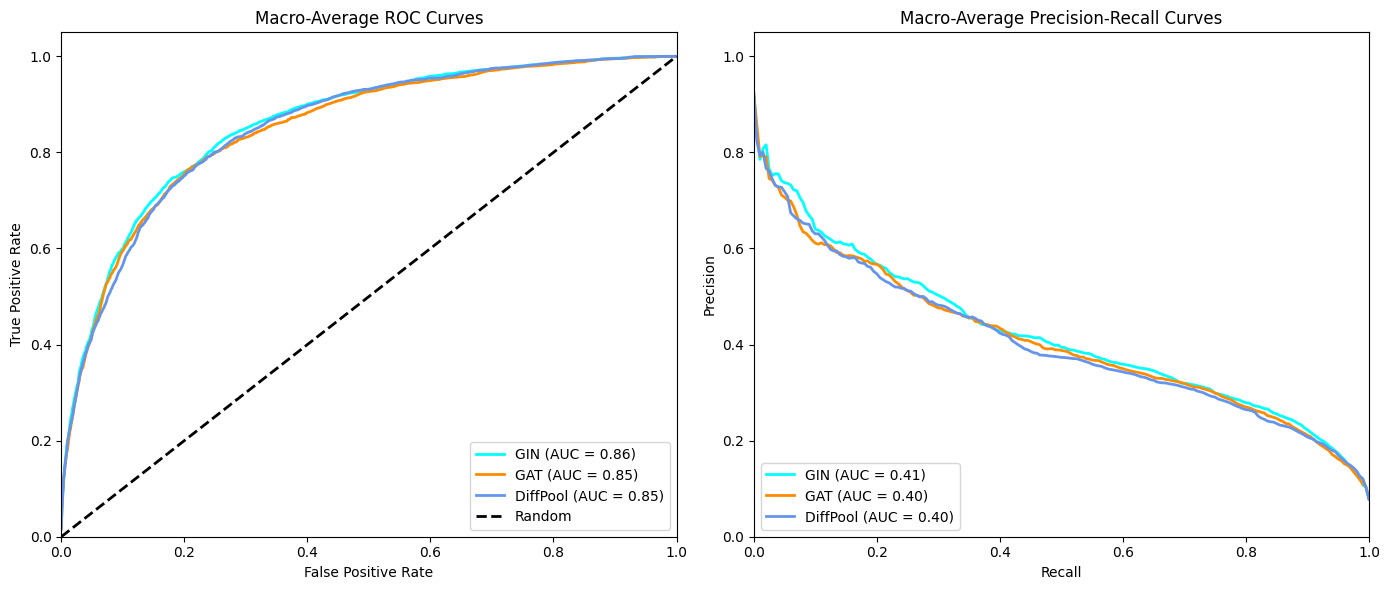


=== AUC Summary (Macro) ===


,AUC-ROC (Macro),AUC-PR (Macro)
Model,,
GIN,0.8589,0.4143
GAT,0.8507,0.4039
DiffPool,0.8527,0.3994


In [150]:
# ---------- Helper Functions ----------
def plot_roc_pr_curves_multi(model_results, num_classes, class_names):
    """
    Plot per-model macro-average ROC and PR curves using standard matplotlib.
    model_results: dict -> { 'ModelName': (logits, labels) }
    num_classes: int, number of classes
    class_names: list of str, names of classes
    """
    plt.figure(figsize=(14, 6))
    lw = 2
    colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'yellow'])

    # --- ROC Curves (Macro Average) ---
    plt.subplot(1, 2, 1)
    for model_name, (logits, labels) in model_results.items():
        probs = torch.softmax(logits, dim=1).detach().cpu().numpy()
        labels_np = labels.cpu().numpy()
        y_true_bin = label_binarize(labels_np, classes=np.arange(num_classes))

        # Calculate ROC curve for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(num_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

        # Interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(num_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        # Average and compute AUC
        mean_tpr /= num_classes
        macro_fpr = all_fpr
        macro_tpr = mean_tpr
        macro_roc_auc = auc(macro_fpr, macro_tpr)

        plt.plot(macro_fpr, macro_tpr, color=next(colors), lw=lw,
                 label=f'{model_name} (AUC = {macro_roc_auc:.2f})')


    plt.plot([0, 1], [0, 1], 'k--', lw=lw, label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Macro-Average ROC Curves')
    plt.legend(loc="lower right")

    # --- PR Curves (Macro Average) ---
    plt.subplot(1, 2, 2)
    colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'yellow']) # Reset colors

    for model_name, (logits, labels) in model_results.items():
        probs = torch.softmax(logits, dim=1).detach().cpu().numpy()
        labels_np = labels.cpu().numpy()
        y_true_bin = label_binarize(labels_np, classes=np.arange(num_classes))

        # Calculate PR curve for each class
        precision = dict()
        recall = dict()
        average_precision = dict()
        for i in range(num_classes):
            precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], probs[:, i])
            average_precision[i] = average_precision_score(y_true_bin[:, i], probs[:, i])

        # A "macro-average" precision-recall score is the unweighted mean of the per-class
        # average precision scores. Plotting a macro PR curve is less standard than macro ROC.
        # A common way is to average precision at each recall threshold.
        # Let's calculate mean precision at interpolated recall levels.

        # Aggregate all recall points
        all_recall = np.unique(np.concatenate([recall[i] for i in range(num_classes)]))

        # Interpolate all PR curves at this points
        mean_precision = np.zeros_like(all_recall)
        for i in range(num_classes):
            # Need to sort recall in increasing order for interp
            sorted_recall_indices = np.argsort(recall[i])
            mean_precision += np.interp(all_recall, recall[i][sorted_recall_indices], precision[i][sorted_recall_indices])

        # Average and compute AUC
        mean_precision /= num_classes
        macro_recall = all_recall
        macro_precision = mean_precision
        # Note: AUC for the interpolated macro PR curve is not the same as average_precision_score(macro)
        # Use the average_precision_score(macro) calculated in evaluate_metrics_collect for the score
        macro_pr_auc_score = average_precision_score(y_true_bin, probs, average='macro')


        plt.plot(macro_recall, macro_precision, color=next(colors), lw=lw,
                 label=f'{model_name} (AUC = {macro_pr_auc_score:.2f})') # Use macro score here


    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Macro-Average Precision-Recall Curves')
    plt.legend(loc="lower left")

    plt.tight_layout()
    plt.show()


def compute_auc_scores_multi(model_results, num_classes):
    """
    Compute macro AUC-ROC and AUC-PR scores for each model in multi-class.
    """
    auc_scores = {}
    for model_name, (logits, labels) in model_results.items():
        probs = torch.softmax(logits, dim=1).detach().cpu().numpy()
        labels_np = labels.cpu().numpy()
        n_classes = probs.shape[1]
        y_true_bin = label_binarize(labels_np, classes=np.arange(n_classes))

        try:
            # Use score functions that support multi-class averaging
            roc_auc = roc_auc_score(y_true_bin, probs, average='macro')
        except ValueError:
            # This can happen if a class is missing in y_true or y_score
            roc_auc = float('nan') # or handle specifically if needed

        try:
            # Use score functions that support multi-class averaging
            pr_auc = average_precision_score(y_true_bin, probs, average='macro')
        except ValueError:
            # This can happen if a class is missing in y_true or y_score
            pr_auc = float('nan') # or handle specifically if needed


        auc_scores[model_name] = {
            "AUC-ROC (Macro)": roc_auc,
            "AUC-PR (Macro)": pr_auc
        }
    return auc_scores


# ---------- Run Evaluation ---------- #
# Assuming model_results, num_classes, and class_names are defined from previous cells.

model_results = {
    'GIN': (gin_probs, gin_labels),
    'GAT': (gat_probs, gat_labels),
    'DiffPool': (diff_probs, diff_labels)
}

# Plot multi-class AUC-ROC and AUC-PR curves (Macro Average)
# Ensure num_classes and class_names are available
if 'num_classes' in globals() and 'class_names' in globals():
     plot_roc_pr_curves_multi(model_results, num_classes, class_names)
else:
     print("num_classes or class_names not defined. Skipping plotting.")

# Compute macro AUC and Misclassification
if 'num_classes' in globals():
     auc_scores = compute_auc_scores_multi(model_results, num_classes)

     # ---------- Combine Results into Table ---------- #
     summary_data = []
     for model_name, metrics in auc_scores.items():
          # Ensure metrics are floats and not numpy.float64 for display
          summary_data.append({
              'Model': model_name,
              'AUC-ROC (Macro)': float(metrics.get('AUC-ROC (Macro)', float('nan'))),
              'AUC-PR (Macro)': float(metrics.get('AUC-PR (Macro)', float('nan')))
          })


     auc_df = pd.DataFrame(summary_data).set_index('Model')

     # Display summary tables
     print("\n=== AUC Summary (Macro) ===")
     display(auc_df.round(4))


In [151]:
from sklearn.model_selection import KFold

def kfold_cross_validate(
        model_cls,
        arch_config,
        best_hparams,
        dataset,
        num_classes,
        device=device,
        k=5,
        epochs=5,
    ):
    """
    K-fold cross validation for DGL GNN models.
    Returns list of accuracies for all folds.
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold = 1
    fold_accuracies = []

    print(f"\n===== {k}-Fold Cross Validation =====")

    for train_idx, val_idx in kf.split(range(len(dataset))):

        print(f"\n---- Fold {fold}/{k} ----")

        train_subset = torch.utils.data.Subset(dataset, train_idx)
        val_subset   = torch.utils.data.Subset(dataset, val_idx)

        arch_cfg_clean = clean_arch_config(arch_config)

        # no test set inside CV, eval = val set
        model, history, test_metrics = final_train_and_report(
            model_cls=model_cls,
            arch_config=arch_cfg_clean,
            best_hparams=best_hparams,
            device=device,
            epochs=epochs
        )

        acc = metrics['accuracy']
        fold_accuracies.append(acc)
        fold += 1

    print("\nFinal Test Metrics:")
    # Display test_metrics as a DataFrame for better readability
    metrics_df = pd.DataFrame([test_metrics])
    display(metrics_df)

    print(f"\n=== K-Fold Mean Accuracy: {np.mean(fold_accuracies):.4f}")
    print(f"Accuracies per fold: {fold_accuracies}")

    return fold_accuracies


### Summary and Discussion of Model Performance
Based on the comparative table:

**Accuracy:**

- **GIN** achieved the highest accuracy at approximately 0.3985.
- **GAT** followed closely with an accuracy of approximately 0.3965.
- **DiffPool** had the lowest accuracy at about 0.3954.  

**AUC-ROC (Area Under the Receiver Operating Characteristic Curve):**

- **GIN** showed the highest AUC-ROC at approximately 0.8589.
DiffPool was very close behind with an AUC-ROC of about 0.8527.
- **GAT** lagged slightly in this metric as well, with an AUC-ROC of around 0.8507.
AUC-PR (Area Under the Precision-Recall Curve):

- **GIN** performed best with an AUC-PR of approximately 0.4143.
GAT was slightly lower at about 0.4039.
- **DiffPool** again showed the lowest performance at approximately 0.3994.

**Misclassification Percentage:**

This metric is directly derived from accuracy (1 - accuracy). Consequently, GIN has the lowest misclassification percentage (60.15%), followed by GAT (60.35%), and DiffPool has the highest (60.46%).

**Overall Observations:**

- **GIN and GAT outperform DiffPool:** Both GIN and GAT models consistently achieved better performance across all evaluated metrics compared to DiffPool. This suggests that for this specific RNA secondary structure classification task, a hierarchical pooling approach (like DiffPool) might not be as effective as direct node aggregation (GIN) or attention mechanisms (GAT) given the current architectural choices and training setup.
- **GIN and GAT are comparable:** The performance difference between GIN and GAT is marginal, with GIN showing a slight edge in accuracy and AUC-PR, while GAT has a tiny lead in AUC-ROC. This indicates that while attention mechanisms in GAT might provide some benefit, the simpler MLP-based aggregation of GIN is also highly effective for this dataset.
- **Low Absolute Performance:** It's important to note that even the best-performing models (GIN and GAT) achieve accuracies around 39-40%. This suggests that the RNA secondary structure classification task is challenging, possibly due to high inter-class similarity, complex graph structures, or limitations of the chosen node features. There's significant room for improvement, potentially through more sophisticated node feature engineering, larger datasets, more complex GNN architectures, or advanced training techniques. The high misclassification percentages (around 60%) further highlight this challenge.
